In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# CHEKING DISK STORAGE

In [2]:
import shutil

# Get disk space details
total, used, free = shutil.disk_usage("/")

# Convert to human-readable format
def format_size(size):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024

print()
print(f"Total Space: {format_size(total)}")
print(f"Used Space: {format_size(used)}")
print(f"Free Space: {format_size(free)}")
print()


Total Space: 915.32 GB
Used Space: 730.87 GB
Free Space: 137.88 GB



In [3]:
import os

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            # Add file size, skipping broken symbolic links
            if os.path.exists(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

def print_directory_size(directory):
    size_bytes = get_directory_size(directory)
    # Convert bytes to a human-readable format (KB, MB, GB)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            print(f"Size of '{directory}': {size_bytes:.2f} {unit}")
            break
        size_bytes /= 1024

print()
# Example usage
preprocessed_files_path = "data/train_data/preprocessed_files"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

preprocessed_files_path = "executions"  # Change this to your target directory
print_directory_size(preprocessed_files_path)
print()


Size of 'data/train_data/preprocessed_files': 3.77 GB
Size of 'executions': 14.82 GB



# SPECIFY EXECUTION ID TO RESUME TUNING


In [4]:
import os

############### EXECUTION SETTINGS ###############

PARENT_EXECUTION_DIR = "executions/swin_unetr_v2/tuning-train-test"

############## EXECUTION ID ######################

EXECUTION_ID = 175 # Update ID

execution_dir = os.path.join(PARENT_EXECUTION_DIR, f"id={EXECUTION_ID}")
print()
print(f"Hyperparameter Study to be resumed belongs to execution with ID {EXECUTION_ID} located in {execution_dir}")
print()


Hyperparameter Study to be resumed belongs to execution with ID 175 located in executions/swin_unetr_v2/tuning-train-test/id=175



# LOAD EXECUTION SETTINGS

In [5]:
import json
import pprint

# Load JSON
info_execution_json_file_path = os.path.join(execution_dir, "info_execution.json")

with open(info_execution_json_file_path, "r") as json_file:
    info_execution = json.load(json_file)

# pprint.pprint(info_execution, sort_dicts=False, width=100)
print(info_execution)
print()

################### DATA SETTINGS #################

DATA_DIR = info_execution["DATA_SETTINGS"]["DATA_DIR"] 
# Directory where the samples (data and labels folders) and the metadata.json file are located.

NUM_WORKERS = info_execution["DATA_SETTINGS"]["NUM_WORKERS"]
# Number of logical CPU Cores used for parallelizing data laoding


{'INFO_EXECUTION': {'PARENT_EXECUTION_DIR': 'executions/swin_unetr_v2/tuning-train-test', 'EXECUTION_ID': 175, 'EXECUTION_DIR': 'id=175'}, 'DATA_SETTINGS': {'DATA_DIR': 'data/train_data', 'METADATA_DATASET': 'metadata_37_samples.json', 'K_FOLDS': 6, 'NUM_WORKERS': 4, 'SAMPLES_DATASET': ['R_002', 'R_003', 'R_004', 'R_005', 'R_006', 'R_007', 'R_008', 'R_009', 'R_010', 'R_011', 'R_012', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_005', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_010', 'Z_011', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_017', 'Z_018', 'Z_019', 'Z_020'], 'VALIDATION_SET': ['R_002', 'R_003', 'R_011', 'Z_005', 'Z_008', 'Z_014', 'Z_020'], 'TRAIN_TEST_SPLITS': {'SPLIT_0': {'TRAIN_SET': ['R_004', 'R_005', 'R_007', 'R_008', 'R_009', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_006', 'Z_007', 'Z_009', 'Z_010', 'Z_011', 'Z_012', 'Z_015', 'Z_016', 'Z_018', 'Z_019'], 'TEST_SET': ['R_006', 'R_010',

# LOAD DATA SPLITTING INFO

In [6]:
import json
import os


# Load metadata JSON file
metadata_json_path = os.path.join(info_execution["DATA_SETTINGS"]["DATA_DIR"], info_execution["DATA_SETTINGS"]["METADATA_DATASET"])
with open(metadata_json_path, "r") as f:
    metadata = json.load(f)

# Restore validation files
validation_files = {sample: metadata[sample] for sample in info_execution["DATA_SETTINGS"]["VALIDATION_SET"]}
dataset_files = {sample: metadata[sample] for sample in info_execution["DATA_SETTINGS"]["SAMPLES_DATASET"]}
train_test_files = {sample: metadata[sample] for sample in dataset_files if sample not in validation_files}

print("✅ Successfully restored `train_test_files` and `validation_files` from JSON!")

print()
# Pretty-print the configurations
# print("=> Validation Set")
# print()
# pprint.pprint(validation_files_original_copy, sort_dicts=False, width=100)
# print()
# # Pretty-print the configurations
# print("=> Train/Test Splits")
# print()
# pprint.pprint(train_test_splits_orginal_copy, sort_dicts=False, width=100)
# print()

✅ Successfully restored `train_test_files` and `validation_files` from JSON!



# Importing libraries

In [7]:
import optuna
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import pprint
import shutil
import gc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import time
import torchinfo
import ptflops
import random
random.seed(42)
from PIL import Image
import seaborn as sns
import numpy as np
from datetime import timedelta, datetime

# LOAD HYPERPARAMETER TUNNING STUDY

In [8]:
execution_id = EXECUTION_ID

# Create the directory
tuning_dir = os.path.join(execution_dir, 'tuning')

study_storage_path = os.path.join("sqlite:///", tuning_dir, f"optuna_study.db")

# load an existing study
study = optuna.load_study(study_name=f"study_id={execution_id}", storage=study_storage_path)
print(f"Optuna study loaded: {study_storage_path}")
print()

Optuna study loaded: sqlite:///executions/swin_unetr_v2/tuning-train-test/id=175/tuning/optuna_study.db



# BEST TRIAL IN STUDY

## Summary

In [9]:
best_trial_model_info = {
    "model_total_params": study.best_trial.user_attrs["model_total_params"],
    "model_trainable_params": study.best_trial.user_attrs["model_trainable_params"],
    "model_non_trainable_params": study.best_trial.user_attrs["model_non_trainable_params"],
    "model_gflops_inference": study.best_trial.user_attrs["model_gflops_inference"] # IN GFLOPS
}

best_trial_overlap_training = study.best_trial.params["overlap_training"]
best_trial_overlap_training = (best_trial_overlap_training, best_trial_overlap_training)

best_trial_training_config={
    "lr_optimizer": study.best_trial.params["lr_optimizer"],
    "weight_decay_optimizer": study.best_trial.params["weight_decay_optimizer"],
    "warmup_epochs_lr_scheduler": study.best_trial.params["warmup_epochs_lr_scheduler"],
    "max_training_epochs": study.best_trial.params["max_training_epochs"],
    "patience_epochs_early_stopping": study.best_trial.params["patience_epochs_early_stopping"],
    "batch_size_training": study.best_trial.params["batch_size_training"],
    "batch_size_inference": study.best_trial.params["batch_size_inference"],
    "num_batches_grad_accumulation": study.best_trial.params["num_batches_grad_accumulation"],
    "overlap_training": best_trial_overlap_training,
    "overlap_inference": eval(study.best_trial.params["overlap_inference"]),
    "post_processing_strategy": study.best_trial.params["post_processing_strategy"],
    "pre_processing_strategy": study.best_trial.params["pre_processing_strategy"]
}
# Architecture
best_trial_model_spatial_input_dim = study.best_trial.params["model_spatial_input_dims"]
best_trial_exponent_model_temporal_input_dim = study.best_trial.params["exponent_model_temporal_input_dim"]
best_trial_model_temporal_input_dim = 64*(2**best_trial_exponent_model_temporal_input_dim)
best_trial_model_input_dimensions = (best_trial_model_spatial_input_dim, best_trial_model_spatial_input_dim) + (best_trial_model_temporal_input_dim,)
best_trial_initial_feature_embedding_size = 12*(2**study.best_trial.params["exponent_initial_feature_embedding_size"])

# Architecture Configuration
best_trial_architecture_config={
    "use_SWIN_v2": study.best_trial.params["use_SWIN_v2"],
    "model_input_dimensions": best_trial_model_input_dimensions,
    "model_input_channels": 1,
    "model_output_channels": 2, # 2 output channels = 2 output classes (i.e. defective/non-defective)
    "initial_feature_embedding_size": best_trial_initial_feature_embedding_size,
    "patch_embedding_size": (study.best_trial.params["patch_embedding_size"], study.best_trial.params["patch_embedding_size"], study.best_trial.params["patch_embedding_size"]),
    "num_swin_transformer_blocks_in_layers": (study.best_trial.params["num_swin_transformer_blocks_in_layers"], study.best_trial.params["num_swin_transformer_blocks_in_layers"], study.best_trial.params["num_swin_transformer_blocks_in_layers"], study.best_trial.params["num_swin_transformer_blocks_in_layers"]),
    "mlp_ratio": study.best_trial.params["mlp_ratio"],
}

best_trial_initial_attention_head = study.best_trial.params["initial_attention_head"]
best_trial_attention_heads = (best_trial_initial_attention_head, best_trial_initial_attention_head*2, best_trial_initial_attention_head*4, best_trial_initial_attention_head*8)

# Attention Configuration
best_trial_attention_config={
    "heads": best_trial_attention_heads,
    "window_size": (study.best_trial.params["attention_window_size"], study.best_trial.params["attention_window_size"], study.best_trial.params["attention_window_size"]),
    "qkv_bias": study.best_trial.params["attention_qkv_projections_bias"],
    "drop_rate": study.best_trial.params["attention_weights_drop_rate"]
}

# Normalization Configuration
best_trial_normalization_config={
    "use_norm_in_swinViT_after_layer": study.best_trial.params["layer_normalization_after_each_layer_in_SWIN_Transformer"],
    "patch_norm_in_swinViT": study.best_trial.params["normalization_after_patch_embedding"],
    "unet_block_norm_type": study.best_trial.params["type_normalization_in_UNET_block"]
}

# Regularization Configuration
best_trial_regularization_config={
    "transformer_block_drop_rate": study.best_trial.params["transformer_block_drop_rate"],
    "transformer_block_residual_block_dropout_path_rate": study.best_trial.params["transformer_block_residual_block_dropout_path_rate"],
}

# Combine all configs into a single dictionary
best_trial_config = {
    "TRIAL_ID": study.best_trial.number,
    "VAL_LOSS": study.best_trial.value,
    "MODEL_INFO": best_trial_model_info,
    "TRAINING_CONFIG": best_trial_training_config,
    "ARCHITECTURE_CONFIG": best_trial_architecture_config,
    "ATTENTION_CONFIG": best_trial_attention_config,
    "NORMALIZATION_CONFIG": best_trial_normalization_config,
    "REGULARIZATION_CONFIG": best_trial_regularization_config
}

print()
print(f"{'=' * 50}")
print(f"{'=' * 18} BEST TRIAL: {study.best_trial.number} {'=' * 17}")
print(f"{'=' * 16} Val. Loss: {study.best_trial.value:.4f} {'=' * 16}")
print(f"{'=' * 50}")
print()

print(f"Total Parameters: {study.best_trial.user_attrs['model_total_params']}")
print(f"Trainable Parameters: {study.best_trial.user_attrs['model_trainable_params']}")
print(f"Non-Trainable Parameters: {study.best_trial.user_attrs['model_non_trainable_params']}")
print(f"FLOPs: {study.best_trial.user_attrs['model_gflops_inference'] :.3f} GFLOPs")

print()
print()

# Pretty-print the configurations
pprint.pprint(best_trial_config, sort_dicts=False, width=100)

print()


================== BEST TRIAL: 49 =================
================ Val. Loss: 0.1156 ================

Total Parameters: 117538730
Trainable Parameters: 117538730
Non-Trainable Parameters: 0
FLOPs: 244.865 GFLOPs


{'TRIAL_ID': 49,
 'VAL_LOSS': 0.1155502647161483,
 'MODEL_INFO': {'model_total_params': 117538730,
                'model_trainable_params': 117538730,
                'model_non_trainable_params': 0,
                'model_gflops_inference': 244.864654336},
 'TRAINING_CONFIG': {'lr_optimizer': 0.0005995038308730242,
                     'weight_decay_optimizer': 0.0004424922827660897,
                     'warmup_epochs_lr_scheduler': 7,
                     'max_training_epochs': 10000,
                     'patience_epochs_early_stopping': 17,
                     'batch_size_training': 1,
                     'batch_size_inference': 1,
                     'num_batches_grad_accumulation': 2,
                     'overlap_training': (0.3, 0.3),
                     'ov

## Validation Results (Ground Truth vs Prediction)

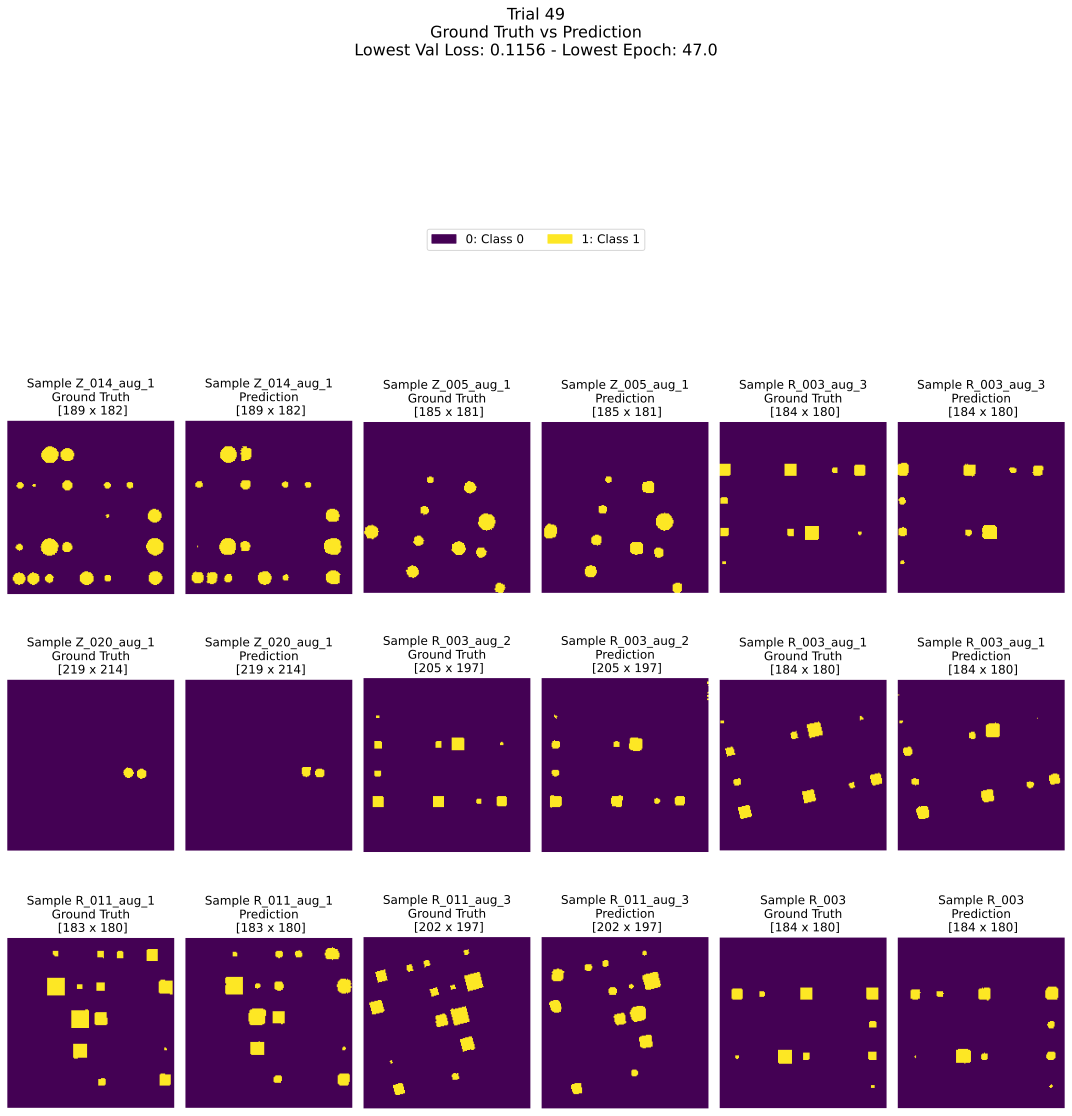

In [10]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"validation_gt_vs_pred.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path

## Training vs Validation Loss Evolution

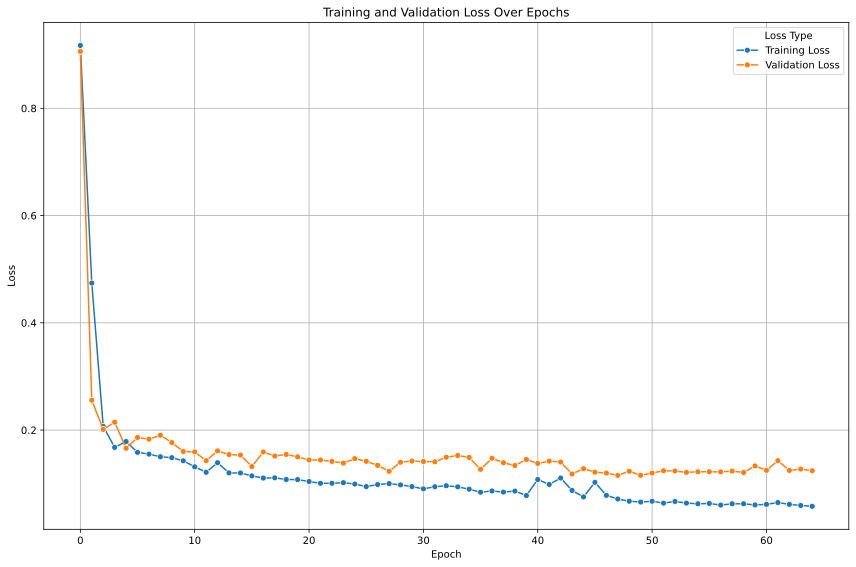

In [11]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"train_val_loss_evolution.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path

# INFO HYPERPARAMETER STUDY LOADED

In [12]:
import os
import plotly.io as pio

# Set default renderer for Jupyter Notebook/Lab
pio.renderers.default = 'iframe'

# Visualize results
from optuna.visualization import plot_optimization_history

# Display the plot
plot_optimization_history(study)

In [13]:
# Visualize results
from optuna.visualization import plot_param_importances
import os


# Display the plot
plot_param_importances(study)

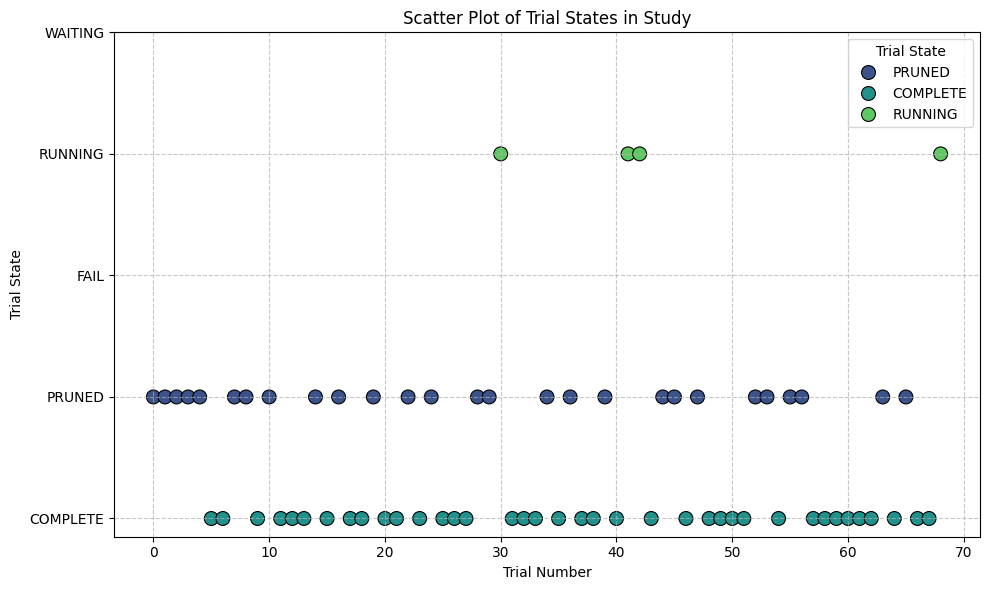

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Example data: Map trial states to numeric values
trial_states = [trial.state.name for trial in study.trials]
trial_numbers = range(len(study.trials))
state_mapping = {"COMPLETE": 1, "PRUNED": 2, "FAIL": 3, "RUNNING": 4, "WAITING": 5}
mapped_states = [state_mapping.get(state, 0) for state in trial_states]

# Create a DataFrame for plotting
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Mapped State": mapped_states,
    "Trial State": trial_states
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="Trial Number",
    y="Mapped State",
    hue="Trial State",  # Add hue for categorical coloring
    palette="viridis",  # Use the Viridis colormap
    s=100,              # Marker size
    edgecolor="k"       # Black edges around markers
)

# Adjust y-axis ticks to display state names
plt.yticks(list(state_mapping.values()), list(state_mapping.keys()))

# Add title, labels, and grid
plt.xlabel("Trial Number")
plt.ylabel("Trial State")
plt.title("Scatter Plot of Trial States in Study")
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


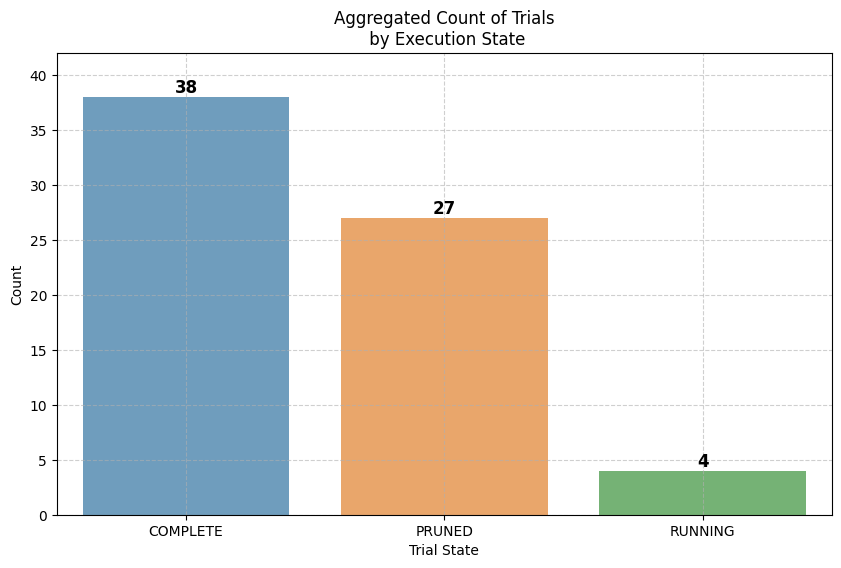

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os

# Recalculate trial_counts if not already defined
trial_states = [trial.state.name for trial in study.trials]
trial_counts = pd.DataFrame(trial_states, columns=["Trial State"]).value_counts().reset_index()
trial_counts.columns = ["Trial State", "Count"]


# Create the plot with different colors for each state
plt.figure(figsize=(10, 6))
sns.barplot(
    data=trial_counts,
    x="Trial State",
    y="Count",
    hue="Trial State",  # Different colors for each state
    dodge=False,  # Ensure only one bar per state
    alpha=0.7
)

plt.title("Aggregated Count of Trials\n by Execution State")
plt.grid(linestyle="--", alpha=0.6)

# Adjust y-axis limits to make space for annotations
max_count = trial_counts["Count"].max()
plt.ylim(0, max_count + math.ceil(max_count * 0.1))  # Add 10% margin above the tallest bar

# Display values on top of each bar
for index, row in trial_counts.iterrows():
    plt.text(
        index, 
        row["Count"] + 0.4, 
        str(row["Count"]), 
        ha="center", 
        fontsize=12, 
        fontweight="bold"
    )


# Show the plot
plt.show()


Total Study Runtime: 10 days, 20:49:58.075412
Average Trial Duration: 2:20:26.667412
Minimum Trial Duration: 0:05:02.247663
Maximum Trial Duration: 8:23:07.667256
Total Time for PRUNED: 2:55:26.298321
Total Time for COMPLETE: 6 days, 5:13:27.083482


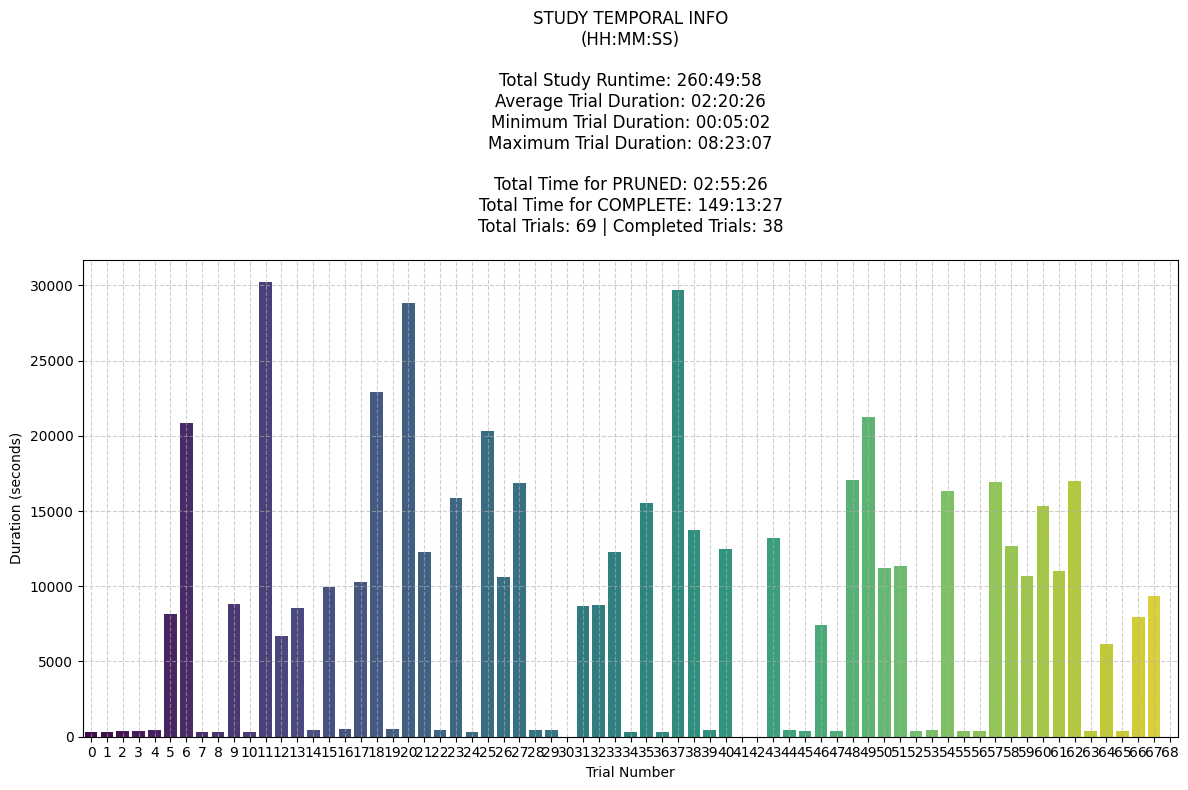

In [16]:
from datetime import timedelta, datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Study-Level Statistics
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)
total_study_runtime = study_end_time - study_start_time

print(f"Total Study Runtime: {total_study_runtime}")

# Trial-Level Statistics
trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in study.trials
    if trial.datetime_start and trial.datetime_complete
]

if trial_durations:
    avg_duration = sum(trial_durations, timedelta()) / len(trial_durations)
    min_duration = min(trial_durations)
    max_duration = max(trial_durations)

    print(f"Average Trial Duration: {avg_duration}")
    print(f"Minimum Trial Duration: {min_duration}")
    print(f"Maximum Trial Duration: {max_duration}")
else:
    print("No completed trials to calculate durations.")

# Time by Trial State
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

state_info_str = ""
for state, total_duration in state_durations.items():
    state_info = f"Total Time for {state.name}: {total_duration}"
    print(state_info)
    state_info_str += state_info + "\n"

# Visualize Trial Durations
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# Convert timedelta objects to HH:MM:SS format
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Format times
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Create DataFrame for Seaborn
data = {
    "Trial Number": trial_numbers,
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Trial Number",
    y="Duration (seconds)",
    hue="Trial Number",  # Use hue to map colors
    dodge=False,  # Prevent multiple bars for each hue
    palette="viridis",  # Apply the color palette
    legend=False        # Hide the legend since it is unnecessary
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
title_text = (
    "STUDY TEMPORAL INFO\n(HH:MM:SS)\n\n"
    f"Total Study Runtime: {formatted_total_runtime}\n"
    f"Average Trial Duration: {formatted_avg_duration}\n"
    f"Minimum Trial Duration: {formatted_min_duration}\n"
    f"Maximum Trial Duration: {formatted_max_duration}\n\n"
    f"{state_info_str}\n"
    f"Total Trials: {len(study.trials)} | Completed Trials: {len(completed_trials)}"
)
plt.title(title_text, loc="center", pad=20)
plt.grid(linestyle="--", alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

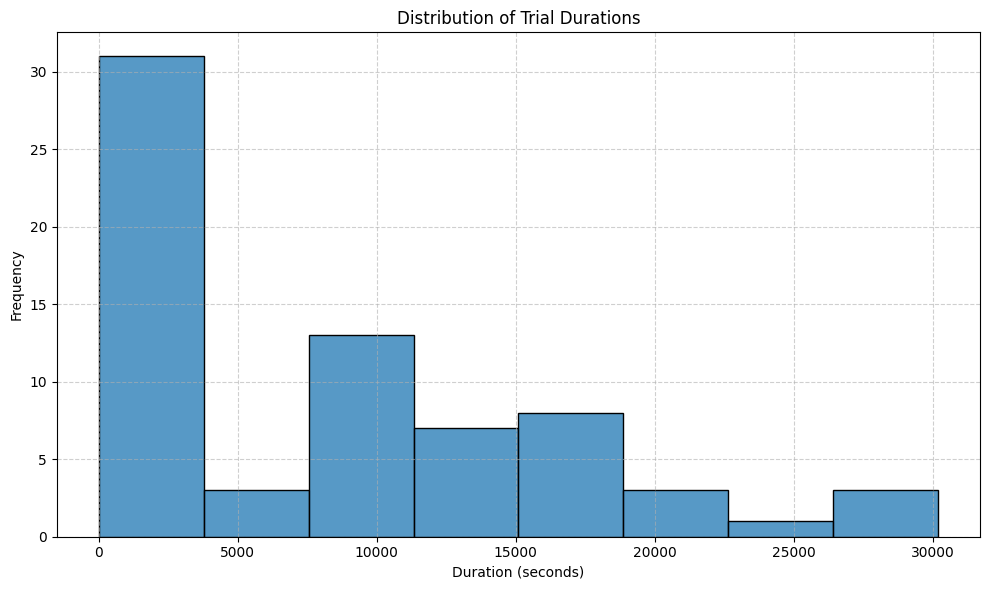

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create DataFrame for durations
data = {
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="Duration (seconds)",
)

# Add labels and title
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title(
    "Distribution of Trial Durations",
    loc="center"
)
plt.grid(linestyle="--", alpha=0.6)


# Show the plot
plt.tight_layout()
plt.show()


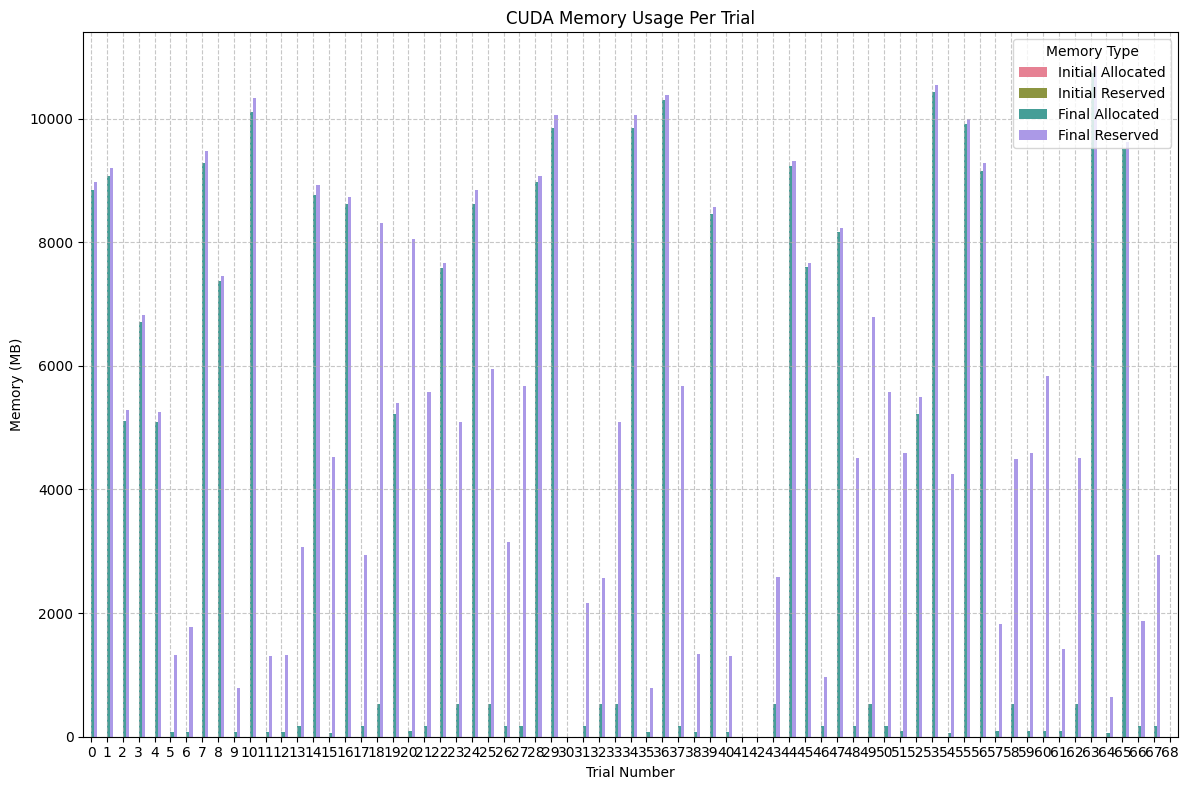

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Extract data for plotting
trial_numbers = list(range(0, len(study.trials)))
initial_allocated = [trial.user_attrs["initial_allocated_cuda_memory"] for trial in study.trials if "initial_allocated_cuda_memory" in trial.user_attrs]
initial_reserved = [trial.user_attrs["initial_reserved_cuda_memory"] for trial in study.trials if "initial_reserved_cuda_memory" in trial.user_attrs]
final_allocated = [trial.user_attrs["final_allocated_cuda_memory"] for trial in study.trials if "final_allocated_cuda_memory" in trial.user_attrs]
final_reserved = [trial.user_attrs["final_reserved_cuda_memory"] for trial in study.trials if "final_reserved_cuda_memory" in trial.user_attrs]

# Prepare the data for Seaborn
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved,
})

# Melt the data for easier plotting with Seaborn
data_melted = data.melt(id_vars="Trial Number", 
                        var_name="Memory Type", 
                        value_name="Memory (MB)")

# Plot the bar chart using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=data_melted,
    x="Trial Number",
    y="Memory (MB)",
    hue="Memory Type",
    dodge=True,  # Ensure separate bars for each memory type
    palette="husl"  # Color palette
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Memory (MB)")
plt.title("CUDA Memory Usage Per Trial")
plt.legend(title="Memory Type", loc="upper right")
plt.grid(linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


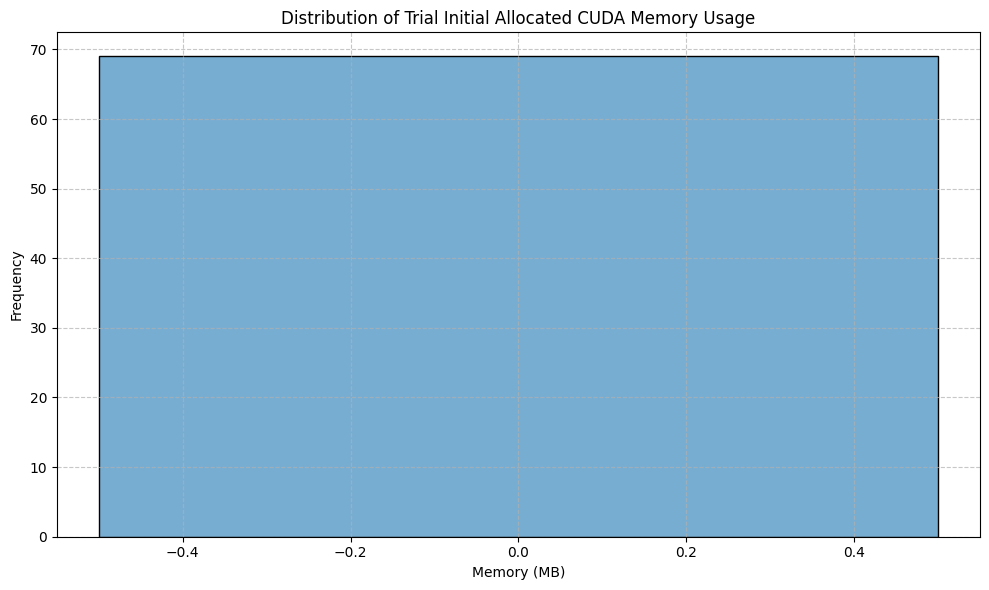

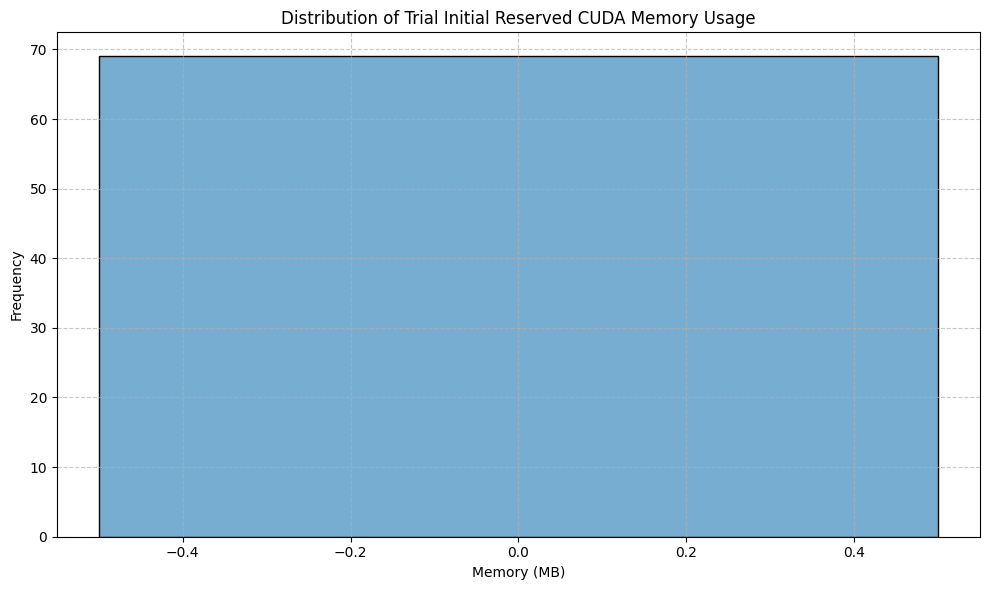

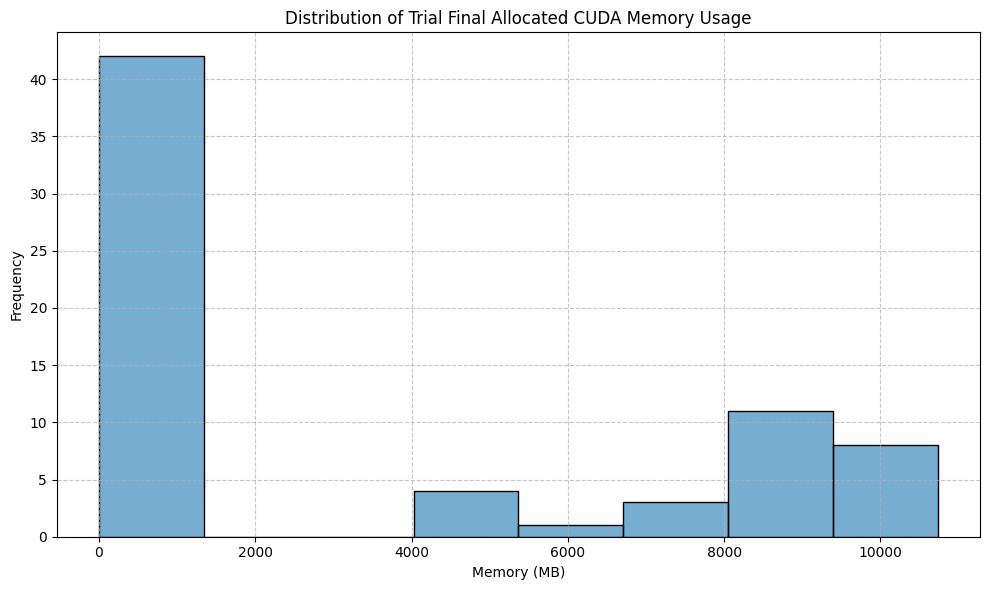

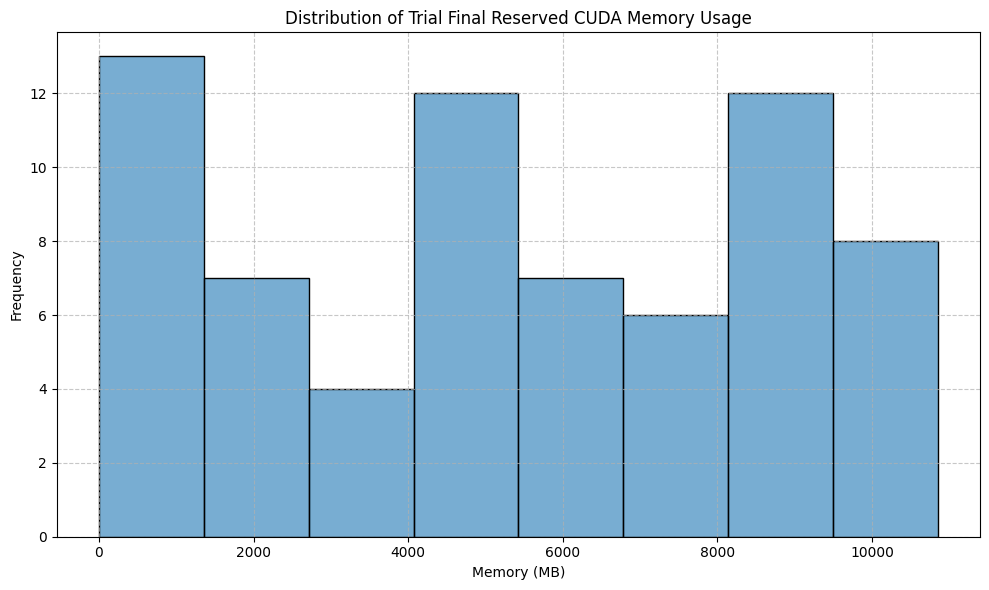

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Extract data for plotting
initial_allocated = [trial.user_attrs["initial_allocated_cuda_memory"] for trial in study.trials if "initial_allocated_cuda_memory" in trial.user_attrs]
initial_reserved = [trial.user_attrs["initial_reserved_cuda_memory"] for trial in study.trials if "initial_reserved_cuda_memory" in trial.user_attrs]
final_allocated = [trial.user_attrs["final_allocated_cuda_memory"] for trial in study.trials if "final_allocated_cuda_memory" in trial.user_attrs]
final_reserved = [trial.user_attrs["final_reserved_cuda_memory"] for trial in study.trials if "final_reserved_cuda_memory" in trial.user_attrs]

# Combine the data into a dictionary for convenience
data = {
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved
}

# Create separate histograms for each memory type
for label, values in data.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(
        values,
        alpha=0.6
    )
    
    # Add labels and title
    plt.xlabel("Memory (MB)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Trial {label} CUDA Memory Usage")
    plt.grid(linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


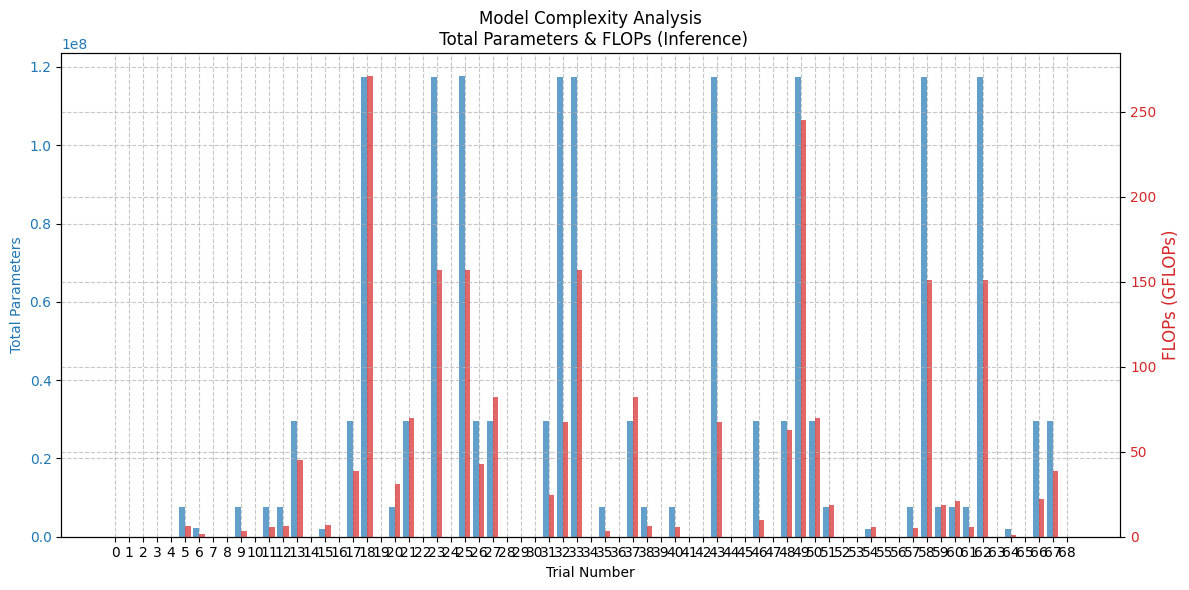

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Extract data for plotting
trial_numbers = list(range(0, len(study.trials)))
total_params = [trial.user_attrs["model_total_params"] for trial in study.trials if "model_total_params" in trial.user_attrs]
flops_inference = [trial.user_attrs["model_gflops_inference"] for trial in study.trials if "model_gflops_inference" in trial.user_attrs]

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar width for better visualization
bar_width = 0.4

# Bar positions
x_indices_params = np.arange(len(total_params))
x_indices_flops = x_indices_params + bar_width

# Plot total parameters as bars
color = 'tab:blue'
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Total Parameters", color=color)
ax1.bar(x_indices_params, total_params, width=bar_width, label="Total Parameters", color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='--', alpha=0.7)

# Second y-axis for FLOPs
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("FLOPs (GFLOPs)", color=color, fontsize=12)
ax2.bar(x_indices_flops, flops_inference, width=bar_width, label="FLOPs (GFLOPs)", color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(linestyle='--', alpha=0.7)

# Adjust x-axis ticks to align with bars
ax1.set_xticks(x_indices_params + bar_width / 2)
ax1.set_xticklabels([f"{i}" for i in range(len(total_params))])

# Add title
plt.title("Model Complexity Analysis\n Total Parameters & FLOPs (Inference)")

# Adjust layout for better spacing
fig.tight_layout()


# Show the plot
plt.show()


# HYPERTUNING

In [ ]:
import os
import sys
import json
import subprocess
import shutil
import time
from datetime import datetime
import optuna
from datetime import datetime, timedelta

# Create tuning directory
tuning_dir = os.path.join(execution_dir, 'tuning')
os.makedirs(tuning_dir, exist_ok=True)
print(f"Tuning directory created: {tuning_dir}")

# Define Optuna study storage path
study_storage_path = os.path.join("sqlite:///", tuning_dir, "optuna_study.db")
study_name = f"study_id={execution_id}"
study = optuna.load_study(study_name=study_name, storage=study_storage_path)

# Create the temporary directory
temp_dir = os.path.join(tuning_dir, "temporary_files")
os.makedirs(temp_dir, exist_ok=True)

# Save train/test file paths as JSON
train_test_files_path = os.path.join(temp_dir, "train_test_files.json")
validation_files_path = os.path.join(temp_dir, "validation_files.json")

with open(train_test_files_path, 'w') as f:
    json.dump(train_test_files, f)
with open(validation_files_path, 'w') as f:
    json.dump(validation_files, f)

# Define the total timeout limit for hyperparameter tuning (7 days in seconds)
TIMEOUT_LIMIT_HP_TUNING = 60 * 60 * 24 * 7  # 7 days

# ------------------- Calculate Total Study Runtime -------------------
# Aggregate durations only for completed or pruned trials
trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in study.trials
    if trial.datetime_start and trial.datetime_complete and
       trial.state in [optuna.trial.TrialState.COMPLETE, optuna.trial.TrialState.PRUNED]
]

# Compute total trial duration (timedelta) and convert to seconds
total_trial_duration = sum(trial_durations, timedelta())
total_study_runtime_seconds = total_trial_duration.total_seconds()

# Compute remaining time for tuning
remaining_time_seconds = TIMEOUT_LIMIT_HP_TUNING - total_study_runtime_seconds
remaining_time_delta = timedelta(seconds=remaining_time_seconds)

# Extract days, hours, minutes, and seconds
days = remaining_time_delta.days
hours, remainder = divmod(remaining_time_delta.seconds, 3600)
minutes, seconds = divmod(remainder, 60)

# ------------------- Print Study Information -------------------
print("="*20)
print()
print("\nHyperparameter Tuning Resumption Details:")
print(f" - Study originally started at: {study_start_time}")
print(f" - Study was last stopped at:   {study_end_time}")
print(f" - Total duration of completed/pruned trials: {total_trial_duration}")
print(f" - Remaining time for tuning: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds\n")
print()
print("="*20)

# ------------------- Resume Hyperparameter Tuning -------------------
start_time = datetime.now()
print()
print(f"Resuming Hyperparameter Tuning at: {start_time}\n")
print()


trial_idx = len(study.trials)  

while (datetime.now() - start_time).total_seconds() < remaining_time_seconds:
    print(f"Starting trial #{trial_idx} in a separate process...")

    process = subprocess.Popen(
        ["python", "-u", "run_SWIN_V2_trial.py", study_name, study_storage_path, DATA_DIR, tuning_dir, str(NUM_WORKERS)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        bufsize=1,
        universal_newlines=True
    )

    # Stream output to console in real-time
    for line in iter(process.stdout.readline, ''):
        print(line, end='')
        sys.stdout.flush()

    while process.poll() is None:  
        elapsed_time = (datetime.now() - start_time).total_seconds()
        # Stream output to console in real-time
        for line in iter(process.stdout.readline, ''):
            print(line, end='')
            sys.stdout.flush()
            
        if elapsed_time >= remaining_time_seconds:
            print(f"Timeout exceeded after {elapsed_time:.2f} seconds. Terminating trial #{trial_idx}...")
            process.terminate()
            time.sleep(5)
            if process.poll() is None:
                print("Process did not terminate in time. Force killing it now.")
                process.kill()
            break  
        time.sleep(1)  

    process.wait()
    print(f"Trial #{trial_idx} completed. GPU memory should be freed.\n")
    trial_idx += 1  



# Cleanup: Remove temporary files
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    print(f"Deleted folder: {temp_dir}")
else:
    print(f"Folder does not exist: {temp_dir}")

# ------------------- Compute Execution Time -------------------
end_time = datetime.now()
execution_time = end_time - start_time

print(f"\nHyperparameter Tuning finished at: {end_time}")
print(f"Total Hyperparameter Tuning Resume execution time: {execution_time}\n")



# LOAD STUDY TO SEE STUDY RESULTS AFTER HYPERTUNING IS DONE

In [21]:
# load  study
tuning_dir = os.path.join(execution_dir, 'tuning')
study_storage_path = os.path.join("sqlite:///", tuning_dir, "optuna_study.db")
study_name = f"study_id={execution_id}"
study = optuna.load_study(study_name=f"study_id={execution_id}", storage=study_storage_path)

## Imports

In [22]:
# Standard libraries
import os
import sys
import json
import math
import time
import shutil
from datetime import datetime, timedelta
from collections import defaultdict
import pprint

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.io as pio
from IPython.display import SVG

# Optuna for Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

# Set default renderer for Jupyter Notebook/Lab (for interactive Plotly visuals)
pio.renderers.default = "iframe"

## Optimization History

In [23]:
# Set default Plotly renderer for displaying plots in Jupyter Notebook/Lab
pio.renderers.default = "iframe"

# Generate the optimization history plot for the given Optuna study
fig = plot_optimization_history(study)

# Define the path to save the plot as an SVG file
svg_file_path = os.path.join(tuning_dir, "optimization_history.svg")

# Save the optimization history plot in high resolution
fig.write_image(svg_file_path, format="svg", width=1200, height=800, scale=3)

# Confirm that the plot has been saved
print(f"✅ Optimization history plot saved at: {svg_file_path}")

fig.show()

✅ Optimization history plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/optimization_history.svg


## Parameter Importance

In [24]:
# Generate the parameter importance plot for the given Optuna study
fig = plot_param_importances(study)

# Define the path to save the plot as an SVG file
svg_file_path = os.path.join(tuning_dir, "param_importances.svg")

# Save the parameter importance plot in high resolution
fig.write_image(svg_file_path, format="svg", width=1500, height=800, scale=3)

# Confirm that the plot has been saved
print(f"✅ Parameter importance plot saved at: {svg_file_path}")

fig.show()

✅ Parameter importance plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/param_importances.svg


## Trial States

✅ Study's trial state info plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/trials_state_info_study.svg


/tmp/ipykernel_128634/486277477.py:45: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



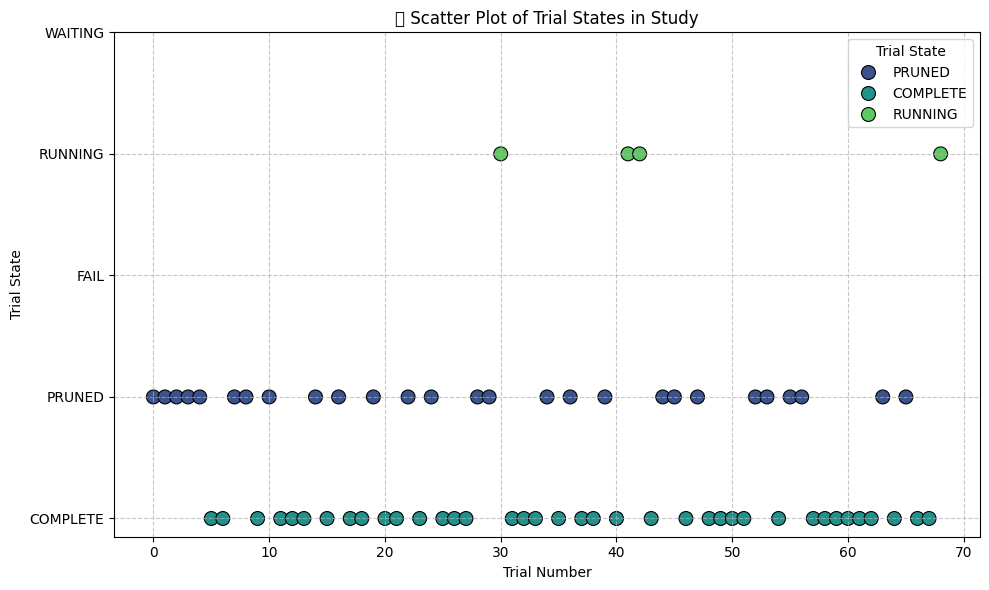

In [25]:
# 🔹 Extract trial state information
trial_states = [trial.state.name for trial in study.trials]
trial_numbers = list(range(len(study.trials)))

# 🔹 Map trial states to numeric values for visualization
state_mapping = {
    "COMPLETE": 1,  # Successfully completed trials
    "PRUNED": 2,    # Trials that were pruned early
    "FAIL": 3,      # Trials that encountered an error
    "RUNNING": 4,   # Currently running trials
    "WAITING": 5    # Trials that are queued
}
mapped_states = [state_mapping.get(state, 0) for state in trial_states]

# 🔹 Create a DataFrame for plotting
df = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Mapped State": mapped_states,
    "Trial State": trial_states
})

# 🔹 Create a scatter plot of trial states using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="Trial Number",
    y="Mapped State",
    hue="Trial State",  # Color trials based on their state
    palette="viridis",  # Use Viridis colormap for better readability
    s=100,              # Set marker size
    edgecolor="k"       # Add black edges around markers for clarity
)

# 🔹 Customize y-axis ticks to display state names
plt.yticks(list(state_mapping.values()), list(state_mapping.keys()))

# 🔹 Add labels, title, and grid for better visualization
plt.xlabel("Trial Number")
plt.ylabel("Trial State")
plt.title("📊 Scatter Plot of Trial States in Study")
plt.grid(True, linestyle="--", alpha=0.7)

# 🔹 Save the plot as an SVG file for high-quality visualization
plot_path_svg = os.path.join(tuning_dir, "trials_state_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")

# 🔹 Confirm the plot was saved successfully
print(f"✅ Study's trial state info plot saved at: {plot_path_svg}")

# 🔹 Show the plot in the notebook
plt.tight_layout()
plt.show()


## Trials Count by Execution State

✅ Study's trial state count plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/trial_state_aggregate_count_info_study.svg


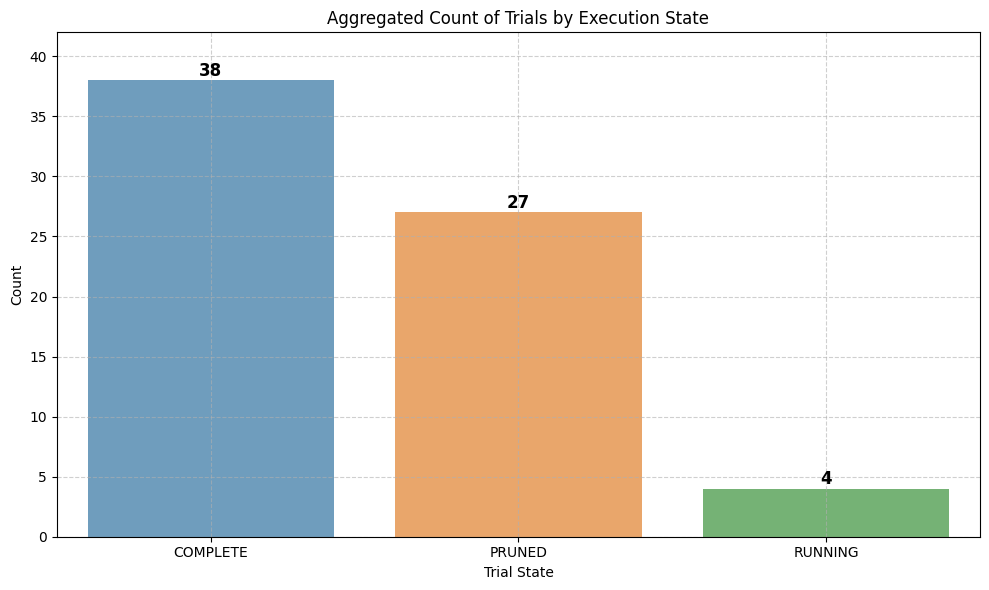

In [26]:
# 🔹 Extract trial states from the study
trial_states = [trial.state.name for trial in study.trials]

# 🔹 Count occurrences of each trial state
trial_counts = pd.DataFrame(trial_states, columns=["Trial State"]).value_counts().reset_index()
trial_counts.columns = ["Trial State", "Count"]

# 🔹 Initialize the figure
plt.figure(figsize=(10, 6))

# 🔹 Create a bar plot with different colors for each state
sns.barplot(
    data=trial_counts,
    x="Trial State",
    y="Count",
    hue="Trial State",  # Different colors for each state
    dodge=False,        # Ensure only one bar per state
    alpha=0.7           # Slight transparency
)

# 🔹 Set title, grid, and adjust y-axis
plt.title("Aggregated Count of Trials by Execution State")
plt.grid(linestyle="--", alpha=0.6)

# 🔹 Adjust y-axis limits to make space for annotations
max_count = trial_counts["Count"].max()
plt.ylim(0, max_count + math.ceil(max_count * 0.1))  # Add a 10% margin above the tallest bar

# 🔹 Display value annotations on top of each bar
for index, row in trial_counts.iterrows():
    plt.text(
        index, 
        row["Count"] + 0.4, 
        str(row["Count"]), 
        ha="center", 
        fontsize=12, 
        fontweight="bold"
    )

# 🔹 Save the plot in SVG format for high-quality storage
svg_path = os.path.join(tuning_dir, "trial_state_aggregate_count_info_study.svg")
plt.savefig(svg_path, format="svg", bbox_inches="tight")

print(f"✅ Study's trial state count plot saved at: {svg_path}")

# 🔹 Show the plot
plt.tight_layout()
plt.show()


##  Study-Wide Temporal Analysis of Trials

📌 Total Study Runtime: 10 days, 20:49:58.075412
⏳ Average Trial Duration: 2:20:26.667412
🔹 Minimum Trial Duration: 0:05:02.247663
🔺 Maximum Trial Duration: 8:23:07.667256
⏱ Total Time for PRUNED: 2:55:26.298321
⏱ Total Time for COMPLETE: 6 days, 5:13:27.083482


/tmp/ipykernel_128634/2651412905.py:117: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



✅ Study's temporal analysis plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/temporal_info_study.svg


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



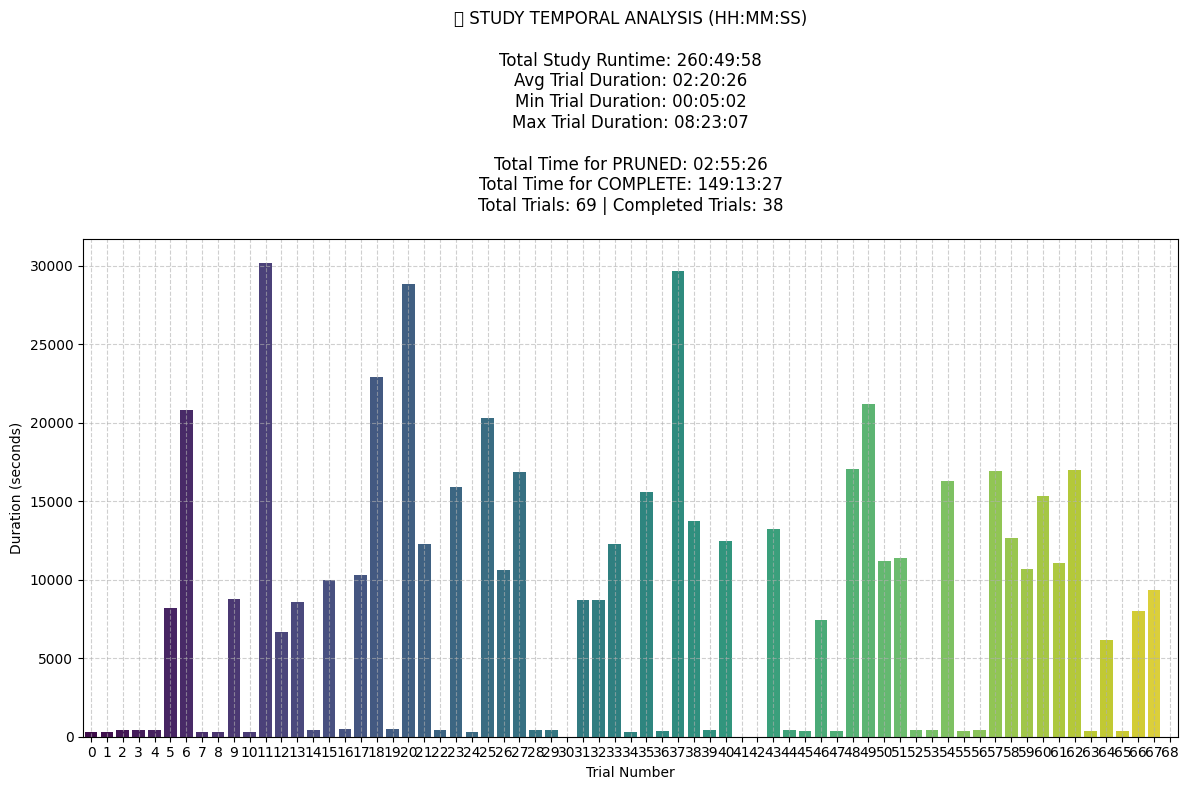

In [27]:
from datetime import timedelta, datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd

# 🔹 Compute total study runtime
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)

total_study_runtime = study_end_time - study_start_time
print(f"📌 Total Study Runtime: {total_study_runtime}")

# 🔹 Compute individual trial durations
trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in study.trials
    if trial.datetime_start and trial.datetime_complete
]

# 🔹 Calculate average, min, and max trial durations
if trial_durations:
    avg_duration = sum(trial_durations, timedelta()) / len(trial_durations)
    min_duration = min(trial_durations)
    max_duration = max(trial_durations)

    print(f"⏳ Average Trial Duration: {avg_duration}")
    print(f"🔹 Minimum Trial Duration: {min_duration}")
    print(f"🔺 Maximum Trial Duration: {max_duration}")
else:
    print("⚠ No completed trials to calculate durations.")

# 🔹 Compute total time spent in each trial state
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

# 🔹 Print the time spent in each state
state_info_str = "\n".join(
    [f"⏱ Total Time for {state.name}: {duration}" for state, duration in state_durations.items()]
)
print(state_info_str)

# 🔹 Convert durations to seconds for visualization
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# 🔹 Helper function to format timedelta as HH:MM:SS
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# 🔹 Format key metrics
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# 🔹 Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)

# 🔹 Extract completed trials
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# 🔹 Create DataFrame for Seaborn visualization
df = pd.DataFrame({"Trial Number": trial_numbers, "Duration (seconds)": trial_durations_in_seconds})

# 🔹 Plot trial durations as a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Trial Number",
    y="Duration (seconds)",
    hue="Trial Number",  # Use hue to map colors
    dodge=False,         # Prevent multiple bars for each hue
    palette="viridis",   # Apply the color palette
    legend=False         # Hide the legend since it is unnecessary
)

# 🔹 Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
title_text = (
    "📊 STUDY TEMPORAL ANALYSIS (HH:MM:SS)\n\n"
    f"Total Study Runtime: {formatted_total_runtime}\n"
    f"Avg Trial Duration: {formatted_avg_duration}\n"
    f"Min Trial Duration: {formatted_min_duration}\n"
    f"Max Trial Duration: {formatted_max_duration}\n\n"
    f"{state_info_str}\n"
    f"Total Trials: {len(study.trials)} | Completed Trials: {len(completed_trials)}"
)
plt.title(title_text, loc="center", pad=20)
plt.grid(linestyle="--", alpha=0.6)

# 🔹 Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "temporal_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"✅ Study's temporal analysis plot saved at: {plot_path_svg}")

# 🔹 Show the plot
plt.tight_layout()
plt.show()


Total Study Runtime: 10 days, 20:49:58.075412
Average Completed Trial Duration: 3:55:37.028513
Minimum Completed Trial Duration: 1:42:11.691066
Maximum Completed Trial Duration: 8:23:07.667256
Total Time for PRUNED: 2:55:26.298321
Total Time for COMPLETE: 6 days, 5:13:27.083482
Study's temporal info plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/temporal_info_study.svg


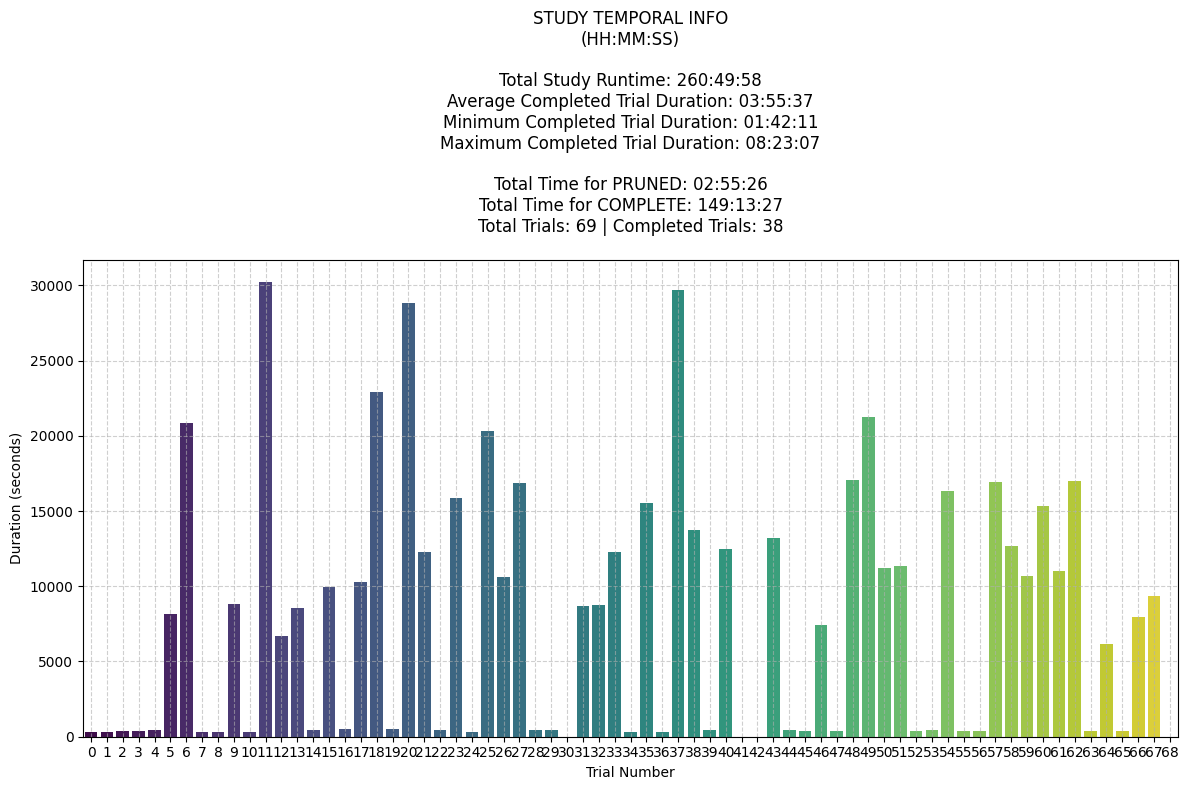

In [35]:
from datetime import timedelta, datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# Study-Level Statistics
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)
total_study_runtime = study_end_time - study_start_time

print(f"Total Study Runtime: {total_study_runtime}")

# Filter only completed trials
completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]

# Trial-Level Statistics (Only for Completed Trials)
completed_trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in completed_trials
    if trial.datetime_start and trial.datetime_complete
]

if completed_trial_durations:
    avg_duration = sum(completed_trial_durations, timedelta()) / len(completed_trial_durations)
    min_duration = min(completed_trial_durations)
    max_duration = max(completed_trial_durations)

    print(f"Average Completed Trial Duration: {avg_duration}")
    print(f"Minimum Completed Trial Duration: {min_duration}")
    print(f"Maximum Completed Trial Duration: {max_duration}")
else:
    print("No completed trials to calculate durations.")
    avg_duration = min_duration = max_duration = timedelta(0)  # Default to zero if no trials are completed

# Time by Trial State
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

state_info_str = ""
for state, total_duration in state_durations.items():
    state_info = f"Total Time for {state.name}: {total_duration}"
    print(state_info)
    state_info_str += state_info + "\n"

# Visualize Trial Durations
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# Convert timedelta objects to HH:MM:SS format
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Format times (Only for Completed Trials)
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)

# Create DataFrame for Seaborn
data = {
    "Trial Number": trial_numbers,
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Trial Number",
    y="Duration (seconds)",
    hue="Trial Number",  # Use hue to map colors
    dodge=False,  # Prevent multiple bars for each hue
    palette="viridis",  # Apply the color palette
    legend=False        # Hide the legend since it is unnecessary
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
title_text = (
    "STUDY TEMPORAL INFO\n(HH:MM:SS)\n\n"
    f"Total Study Runtime: {formatted_total_runtime}\n"
    f"Average Completed Trial Duration: {formatted_avg_duration}\n"
    f"Minimum Completed Trial Duration: {formatted_min_duration}\n"
    f"Maximum Completed Trial Duration: {formatted_max_duration}\n\n"
    f"{state_info_str}\n"
    f"Total Trials: {len(study.trials)} | Completed Trials: {len(completed_trials)}"
)
plt.title(title_text, loc="center", pad=20)
plt.grid(linestyle="--", alpha=0.6)

# Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "temporal_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Study's temporal info plot saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()

## Trial Durations Distribution

✅ Histogram of trial durations saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/trial_duration_histogram.svg


/tmp/ipykernel_128634/3394762699.py:26: UserWarning:

Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.



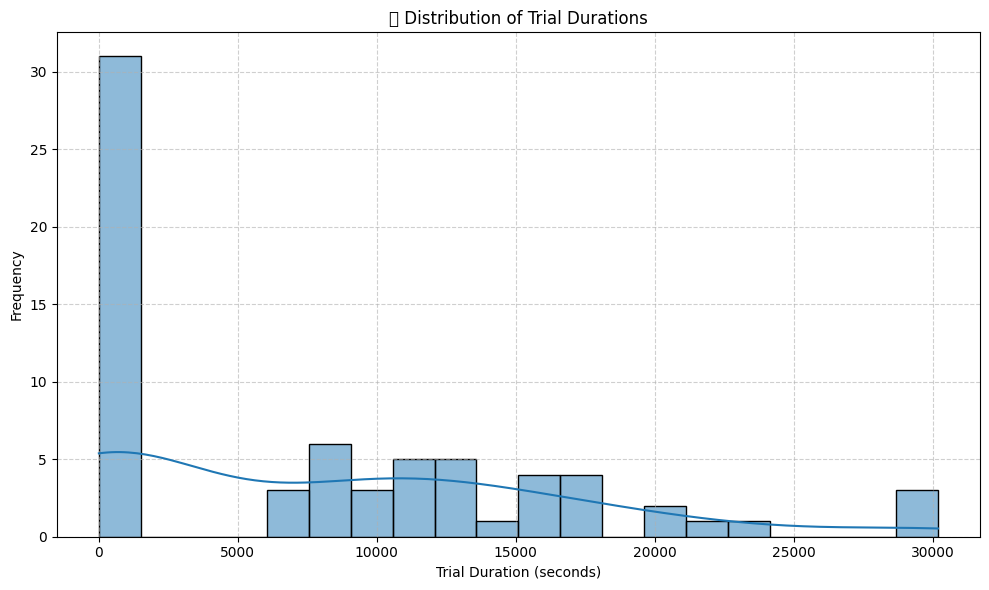

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# 🔹 Create a DataFrame for trial durations
df = pd.DataFrame({"Duration (seconds)": trial_durations_in_seconds})

# 🔹 Create a histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="Duration (seconds)",
    bins=20,  # Adjust the number of bins for better granularity
    kde=True  # Overlay a kernel density estimate for smooth distribution visualization
)

# 🔹 Add labels, title, and grid for clarity
plt.xlabel("Trial Duration (seconds)")
plt.ylabel("Frequency")
plt.title("⏳ Distribution of Trial Durations")
plt.grid(linestyle="--", alpha=0.6)

# 🔹 Save the histogram in SVG format for high-quality visualization
histogram_path_svg = os.path.join(tuning_dir, "trial_duration_histogram.svg")
plt.savefig(histogram_path_svg, format="svg", bbox_inches="tight")

# 🔹 Confirm the plot was saved successfully
print(f"✅ Histogram of trial durations saved at: {histogram_path_svg}")

# 🔹 Display the plot in the notebook
plt.tight_layout()
plt.show()


## CUDA Memory Usage in Trials

/tmp/ipykernel_128634/782037478.py:52: UserWarning:

Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.



✅ CUDA memory usage plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/cuda_memory_usage_info_study.svg


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.



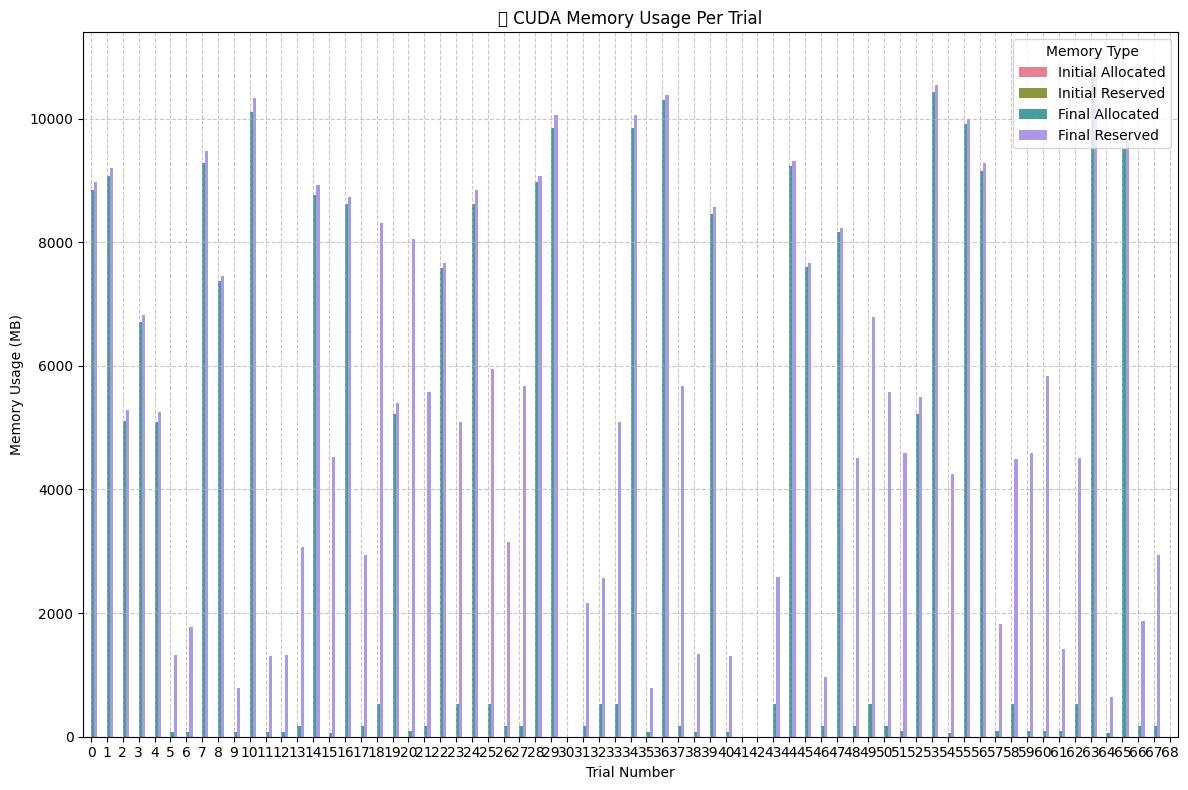

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# 🔹 Extract trial numbers
trial_numbers = list(range(len(study.trials)))

# 🔹 Extract CUDA memory usage from user attributes (if available)
initial_allocated = [trial.user_attrs.get("initial_allocated_cuda_memory", 0) for trial in study.trials]
initial_reserved = [trial.user_attrs.get("initial_reserved_cuda_memory", 0) for trial in study.trials]
final_allocated = [trial.user_attrs.get("final_allocated_cuda_memory", 0) for trial in study.trials]
final_reserved = [trial.user_attrs.get("final_reserved_cuda_memory", 0) for trial in study.trials]

# 🔹 Create a DataFrame for visualization
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved,
})

# 🔹 Reshape data for Seaborn using 'melt' to facilitate grouped bar charts
data_melted = data.melt(
    id_vars="Trial Number", 
    var_name="Memory Type", 
    value_name="Memory (MB)"
)

# 🔹 Plot the CUDA memory usage per trial
plt.figure(figsize=(12, 8))
sns.barplot(
    data=data_melted,
    x="Trial Number",
    y="Memory (MB)",
    hue="Memory Type",
    dodge=True,  # Ensure separate bars for each memory type
    palette="husl"  # Use Husl color palette for better distinction
)

# 🔹 Customize plot with labels, title, and grid
plt.xlabel("Trial Number")
plt.ylabel("Memory Usage (MB)")
plt.title("🚀 CUDA Memory Usage Per Trial")
plt.legend(title="Memory Type", loc="upper right")
plt.grid(linestyle="--", alpha=0.7)

# 🔹 Save the plot as an SVG file for high-quality visualization
plot_path_svg = os.path.join(tuning_dir, "cuda_memory_usage_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")

# 🔹 Confirm the plot was saved successfully
print(f"✅ CUDA memory usage plot saved at: {plot_path_svg}")

# 🔹 Display the plot in the notebook
plt.tight_layout()
plt.show()


## CUDA Memory Usage Distributions

✅ Histogram for Initial Allocated saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/initial_allocated_memory_usage_histogram.svg


/tmp/ipykernel_128634/1159626590.py:35: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



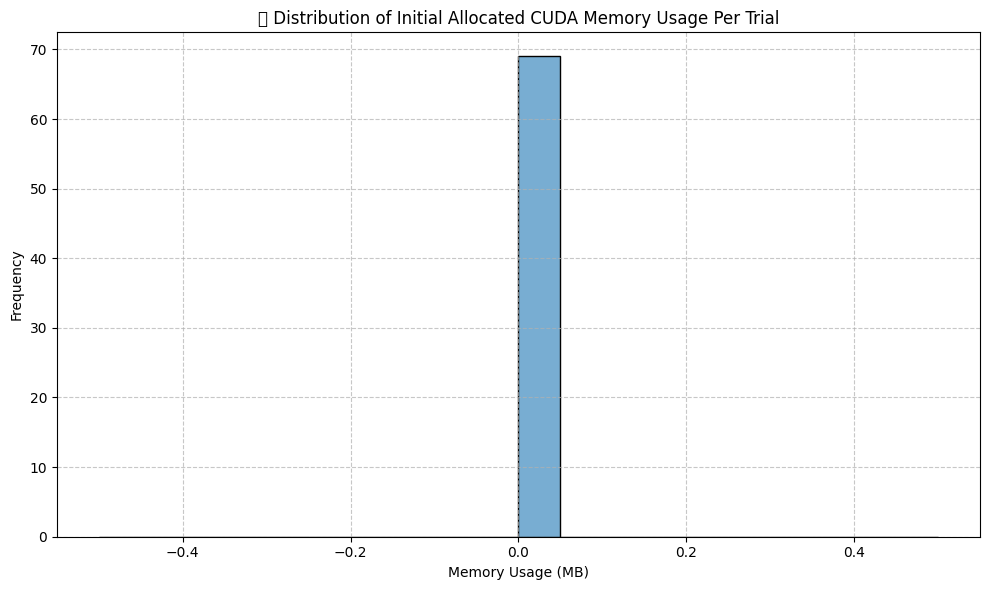

✅ Histogram for Initial Reserved saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/initial_reserved_memory_usage_histogram.svg


/tmp/ipykernel_128634/1159626590.py:35: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



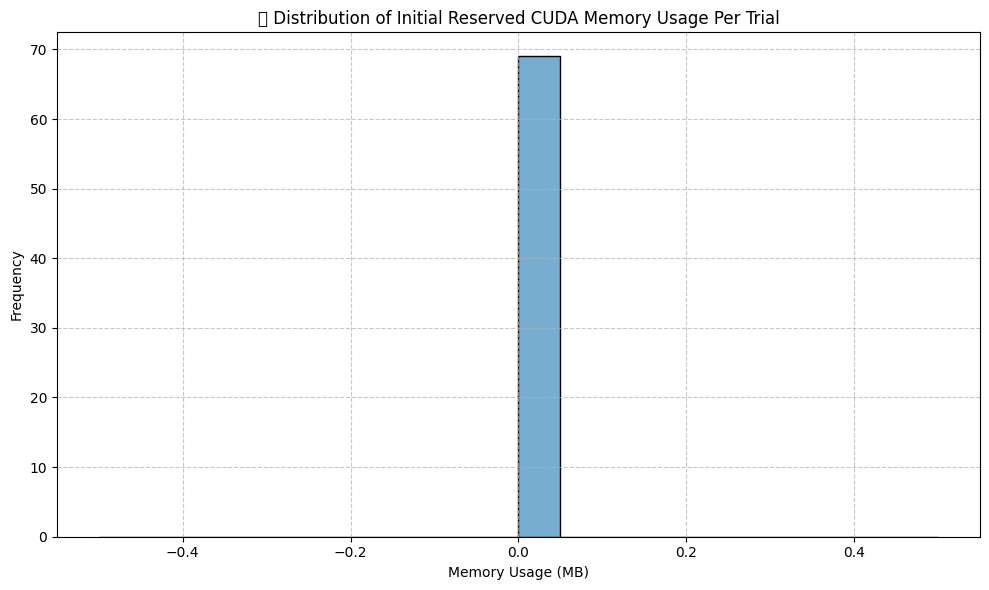

✅ Histogram for Final Allocated saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/final_allocated_memory_usage_histogram.svg


/tmp/ipykernel_128634/1159626590.py:35: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



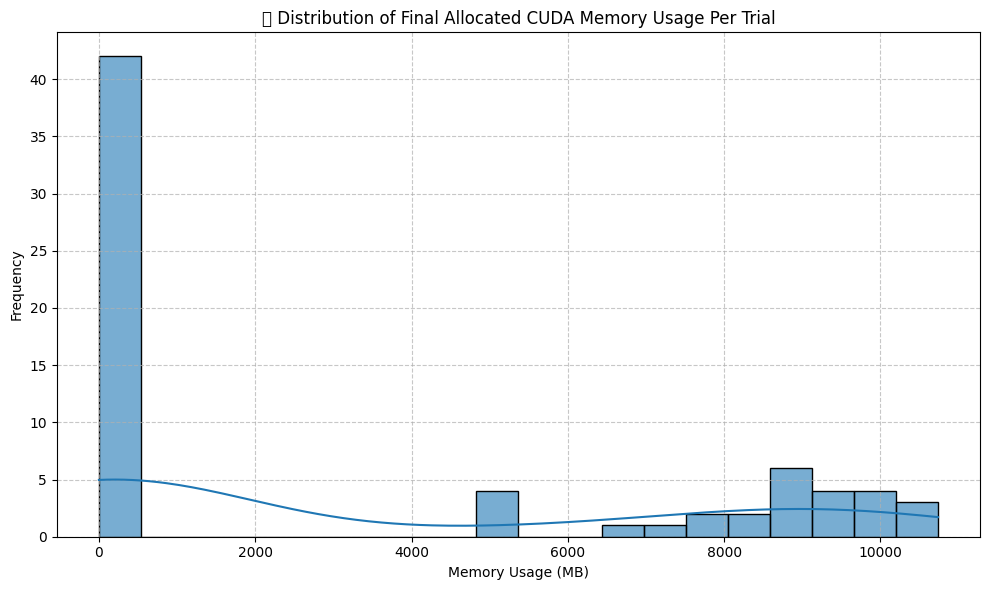

✅ Histogram for Final Reserved saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/final_reserved_memory_usage_histogram.svg


/tmp/ipykernel_128634/1159626590.py:35: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



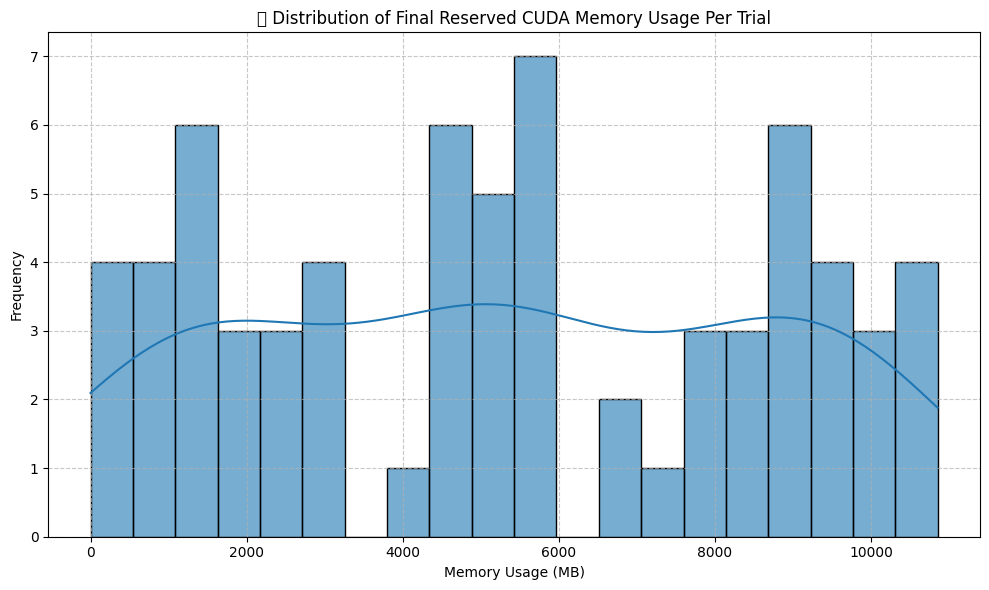

In [30]:
# 🔹 Extract CUDA memory data from user attributes (handling missing values)
initial_allocated = [trial.user_attrs.get("initial_allocated_cuda_memory", 0) for trial in study.trials]
initial_reserved = [trial.user_attrs.get("initial_reserved_cuda_memory", 0) for trial in study.trials]
final_allocated = [trial.user_attrs.get("final_allocated_cuda_memory", 0) for trial in study.trials]
final_reserved = [trial.user_attrs.get("final_reserved_cuda_memory", 0) for trial in study.trials]

# 🔹 Organize data into a dictionary for easier iteration
memory_data = {
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved
}

# 🔹 Generate and save histograms for each memory type
for label, values in memory_data.items():
    plt.figure(figsize=(10, 6))
    
    # Plot histogram using Seaborn
    sns.histplot(
        values,
        bins=20,  # Set number of bins for better granularity
        kde=True,  # Enable Kernel Density Estimation for smooth distribution curves
        alpha=0.6
    )
    
    # 🔹 Customize plot with labels, title, and grid
    plt.xlabel("Memory Usage (MB)")
    plt.ylabel("Frequency")
    plt.title(f"📊 Distribution of {label} CUDA Memory Usage Per Trial")
    plt.grid(linestyle="--", alpha=0.7)

    # 🔹 Save histogram as an SVG file for high-quality visualization
    plot_path_svg = os.path.join(tuning_dir, f"{label.lower().replace(' ', '_')}_memory_usage_histogram.svg")
    plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")

    # 🔹 Confirm the plot was saved successfully
    print(f"✅ Histogram for {label} saved at: {plot_path_svg}")

    # 🔹 Display the plot in the notebook
    plt.tight_layout()
    plt.show()


## Model Complexity Analysis: Total Parameters & FLOPs

/tmp/ipykernel_128634/2618055377.py:44: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_128634/2618055377.py:48: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



✅ Dual bar plot saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/model_params_flops_study_bar.svg


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



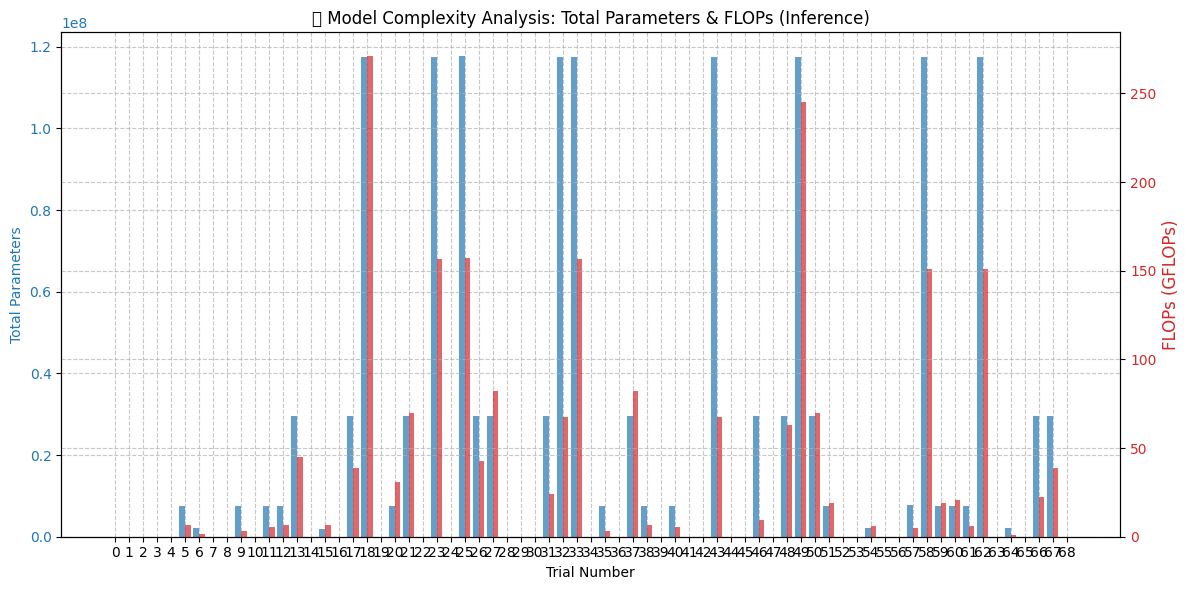

In [31]:
# 🔹 Extract relevant data for plotting
trial_numbers = list(range(len(study.trials)))

# Extract total model parameters and FLOPs per trial, handling missing values
total_params = [trial.user_attrs.get("model_total_params", 0) for trial in study.trials]
flops_inference = [trial.user_attrs.get("model_gflops_inference", 0) for trial in study.trials]

# 🔹 Setup the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define bar width for better spacing
bar_width = 0.4

# Generate x-axis positions for bars
x_indices_params = np.arange(len(total_params))
x_indices_flops = x_indices_params + bar_width  # Shift FLOPs bars to the right

# 🔹 Plot Total Parameters (Left Y-Axis)
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Total Parameters", color="tab:blue")
ax1.bar(
    x_indices_params, total_params, width=bar_width, 
    label="Total Parameters", color="tab:blue", alpha=0.7
)
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(linestyle='--', alpha=0.7)

# 🔹 Add secondary y-axis for FLOPs (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("FLOPs (GFLOPs)", color="tab:red", fontsize=12)
ax2.bar(
    x_indices_flops, flops_inference, width=bar_width, 
    label="FLOPs (GFLOPs)", color="tab:red", alpha=0.7
)
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.grid(linestyle='--', alpha=0.7)

# 🔹 Adjust x-axis ticks to align with bars
ax1.set_xticks(x_indices_params + bar_width / 2)
ax1.set_xticklabels([str(i) for i in trial_numbers])

# 🔹 Add title and improve layout spacing
plt.title("📊 Model Complexity Analysis: Total Parameters & FLOPs (Inference)")
fig.tight_layout()

# 🔹 Save the plot in SVG format for high-quality visualization
plot_path_svg = os.path.join(tuning_dir, "model_params_flops_study_bar.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")

# 🔹 Confirm the plot was saved successfully
print(f"✅ Dual bar plot saved at: {plot_path_svg}")

# 🔹 Display the plot in the notebook
plt.show()


## Extract and Save Best Trial Configuration

In [32]:
# 🔹 Extract Model Information from the Best Trial
best_trial_model_info = {
    "model_total_params": study.best_trial.user_attrs["model_total_params"],
    "model_trainable_params": study.best_trial.user_attrs["model_trainable_params"],
    "model_non_trainable_params": study.best_trial.user_attrs["model_non_trainable_params"],
    "model_gflops_inference": study.best_trial.user_attrs["model_gflops_inference"],  # GFLOPs
}

# 🔹 Process Overlap Training Parameter
best_trial_overlap_training = study.best_trial.params["overlap_training"]
best_trial_overlap_training = (best_trial_overlap_training, best_trial_overlap_training)

# 🔹 Extract Training Configuration
best_trial_training_config = {
    "lr_optimizer": study.best_trial.params["lr_optimizer"],
    "weight_decay_optimizer": study.best_trial.params["weight_decay_optimizer"],
    "warmup_epochs_lr_scheduler": study.best_trial.params["warmup_epochs_lr_scheduler"],
    "max_training_epochs": study.best_trial.params["max_training_epochs"],
    "patience_epochs_early_stopping": study.best_trial.params["patience_epochs_early_stopping"],
    "batch_size_training": study.best_trial.params["batch_size_training"],
    "batch_size_inference": study.best_trial.params["batch_size_inference"],
    "num_batches_grad_accumulation": study.best_trial.params["num_batches_grad_accumulation"],
    "overlap_training": best_trial_overlap_training,
    "overlap_inference": eval(study.best_trial.params["overlap_inference"]),
    "post_processing_strategy": study.best_trial.params["post_processing_strategy"],
    "pre_processing_strategy": study.best_trial.params["pre_processing_strategy"],
}

# 🔹 Extract Architecture Configuration
best_trial_model_spatial_input_dim = study.best_trial.params["model_spatial_input_dims"]
best_trial_exponent_model_temporal_input_dim = study.best_trial.params["exponent_model_temporal_input_dim"]
best_trial_model_temporal_input_dim = 64 * (2**best_trial_exponent_model_temporal_input_dim)

# Define model input dimensions
best_trial_model_input_dimensions = (
    best_trial_model_spatial_input_dim,
    best_trial_model_spatial_input_dim,
    best_trial_model_temporal_input_dim
)

# Calculate initial feature embedding size
best_trial_initial_feature_embedding_size = 12 * (2**study.best_trial.params["exponent_initial_feature_embedding_size"])

best_trial_architecture_config = {
    "use_SWIN_v2": study.best_trial.params["use_SWIN_v2"],
    "model_input_dimensions": best_trial_model_input_dimensions,
    "model_input_channels": 1,
    "model_output_channels": 2,  # 2 classes (defective/non-defective)
    "initial_feature_embedding_size": best_trial_initial_feature_embedding_size,
    "patch_embedding_size": (
        study.best_trial.params["patch_embedding_size"],
        study.best_trial.params["patch_embedding_size"],
        study.best_trial.params["patch_embedding_size"]
    ),
    "num_swin_transformer_blocks_in_layers": (
        study.best_trial.params["num_swin_transformer_blocks_in_layers"],
        study.best_trial.params["num_swin_transformer_blocks_in_layers"],
        study.best_trial.params["num_swin_transformer_blocks_in_layers"],
        study.best_trial.params["num_swin_transformer_blocks_in_layers"]
    ),
    "mlp_ratio": study.best_trial.params["mlp_ratio"],
}

# 🔹 Extract Attention Configuration
best_trial_initial_attention_head = study.best_trial.params["initial_attention_head"]
best_trial_attention_heads = (
    best_trial_initial_attention_head,
    best_trial_initial_attention_head * 2,
    best_trial_initial_attention_head * 4,
    best_trial_initial_attention_head * 8,
)

best_trial_attention_config = {
    "heads": best_trial_attention_heads,
    "window_size": (
        study.best_trial.params["attention_window_size"],
        study.best_trial.params["attention_window_size"],
        study.best_trial.params["attention_window_size"]
    ),
    "qkv_bias": study.best_trial.params["attention_qkv_projections_bias"],
    "drop_rate": study.best_trial.params["attention_weights_drop_rate"],
}

# 🔹 Extract Normalization Configuration
best_trial_normalization_config = {
    "use_norm_in_swinViT_after_layer": study.best_trial.params["layer_normalization_after_each_layer_in_SWIN_Transformer"],
    "patch_norm_in_swinViT": study.best_trial.params["normalization_after_patch_embedding"],
    "unet_block_norm_type": study.best_trial.params["type_normalization_in_UNET_block"],
}

# 🔹 Extract Regularization Configuration
best_trial_regularization_config = {
    "transformer_block_drop_rate": study.best_trial.params["transformer_block_drop_rate"],
    "transformer_block_residual_block_dropout_path_rate": study.best_trial.params["transformer_block_residual_block_dropout_path_rate"],
}

# 🔹 Combine All Configurations into a Single Dictionary
best_trial_config = {
    "TRIAL_ID": study.best_trial.number,
    "VAL_LOSS": study.best_trial.value,
    "MODEL_INFO": best_trial_model_info,
    "TRAINING_CONFIG": best_trial_training_config,
    "ARCHITECTURE_CONFIG": best_trial_architecture_config,
    "ATTENTION_CONFIG": best_trial_attention_config,
    "NORMALIZATION_CONFIG": best_trial_normalization_config,
    "REGULARIZATION_CONFIG": best_trial_regularization_config,
}

# 🔹 Save Best Trial Configuration as a JSON File
info_best_trial_json_file_path = os.path.join(tuning_dir, "best_trial", "best_trial_summary_info.json")
with open(info_best_trial_json_file_path, "w") as json_file:
    json.dump(best_trial_config, json_file, indent=4)

# ✅ Confirm the JSON file was saved successfully
print(f"✅ Best trial config JSON file saved at: {info_best_trial_json_file_path}")

# 🔹 Print Best Trial Summary
print("\n" + "=" * 50)
print(f"🎯 BEST TRIAL: {study.best_trial.number}".center(50))
print(f"📉 Val. Loss: {study.best_trial.value:.4f}".center(50))
print("=" * 50 + "\n")

# 🔹 Print Model Information
print(f"🔹 Total Parameters: {study.best_trial.user_attrs['model_total_params']}")
print(f"🔹 Trainable Parameters: {study.best_trial.user_attrs['model_trainable_params']}")
print(f"🔹 Non-Trainable Parameters: {study.best_trial.user_attrs['model_non_trainable_params']}")
print(f"🔹 FLOPs: {study.best_trial.user_attrs['model_gflops_inference'] :.3f} GFLOPs\n")

# 🔹 Pretty-print Best Trial Configuration
pprint.pprint(best_trial_config, sort_dicts=False, width=100)


✅ Best trial config JSON file saved at: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/best_trial/best_trial_summary_info.json

                 🎯 BEST TRIAL: 49                 
               📉 Val. Loss: 0.1156                

🔹 Total Parameters: 117538730
🔹 Trainable Parameters: 117538730
🔹 Non-Trainable Parameters: 0
🔹 FLOPs: 244.865 GFLOPs

{'TRIAL_ID': 49,
 'VAL_LOSS': 0.1155502647161483,
 'MODEL_INFO': {'model_total_params': 117538730,
                'model_trainable_params': 117538730,
                'model_non_trainable_params': 0,
                'model_gflops_inference': 244.864654336},
 'TRAINING_CONFIG': {'lr_optimizer': 0.0005995038308730242,
                     'weight_decay_optimizer': 0.0004424922827660897,
                     'warmup_epochs_lr_scheduler': 7,
                     'max_training_epochs': 10000,
                     'patience_epochs_early_stopping': 17,
                     'batch_size_training': 1,
                     'batch_size_inferen

## Best Trial's Validation Ground Truth vs. Prediction Masks

📄 Displaying SVG file: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/best_trial/validation_gt_vs_pred.svg


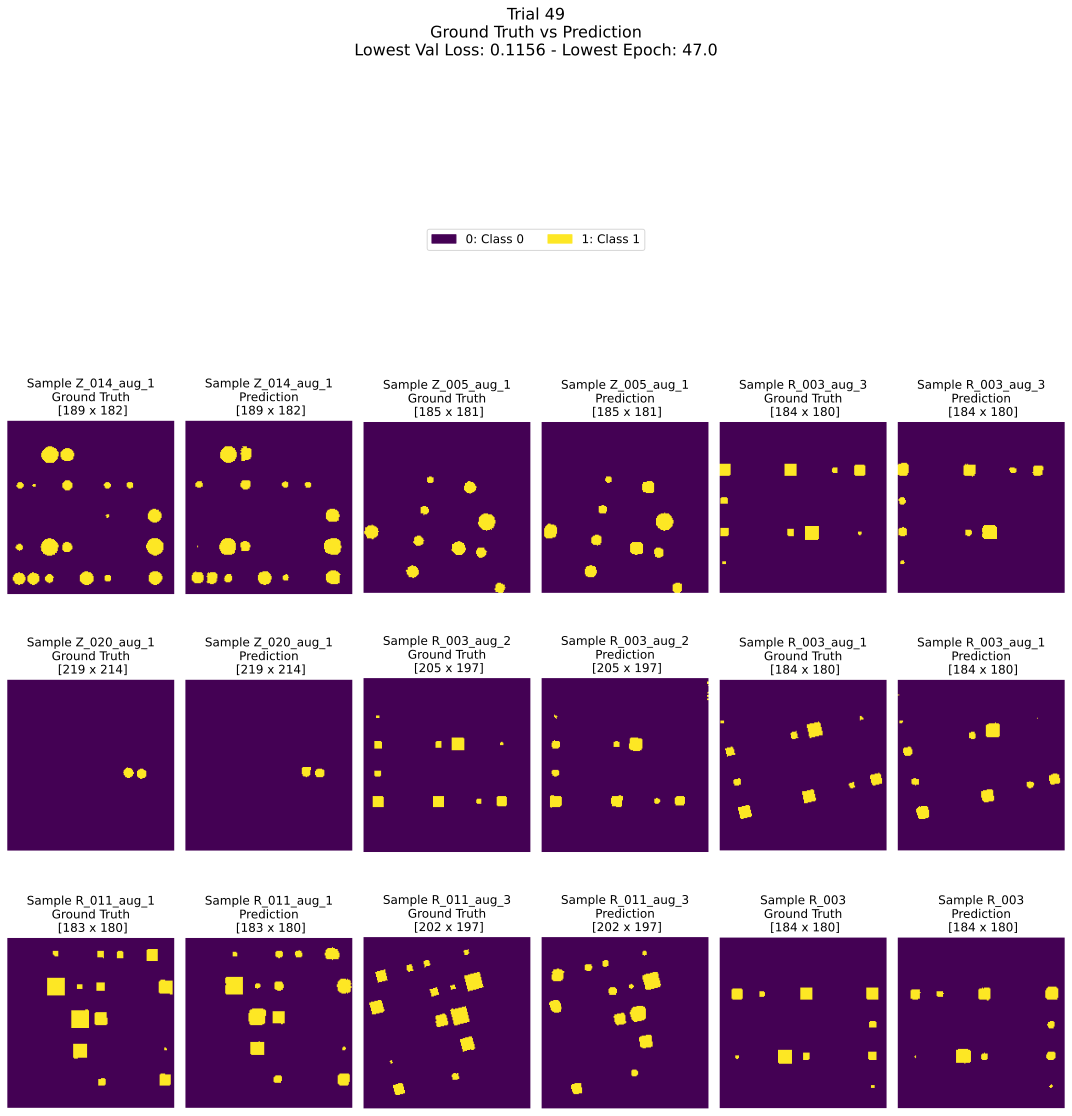

In [33]:
# 🔹 Define the path to the saved SVG file for the best trial's validation results
svg_file_path = os.path.join(tuning_dir, "best_trial", "validation_gt_vs_pred.svg")

# ✅ Display the SVG file inside the Jupyter Notebook
print(f"📄 Displaying SVG file: {svg_file_path}")
SVG(svg_file_path)  # Loads and renders the SVG image in the notebook

## Best Trial's Training & Validation Loss Evolution

📄 Displaying SVG file: executions/swin_unetr_v2/tuning-train-test/id=175/tuning/best_trial/train_val_loss_evolution.svg


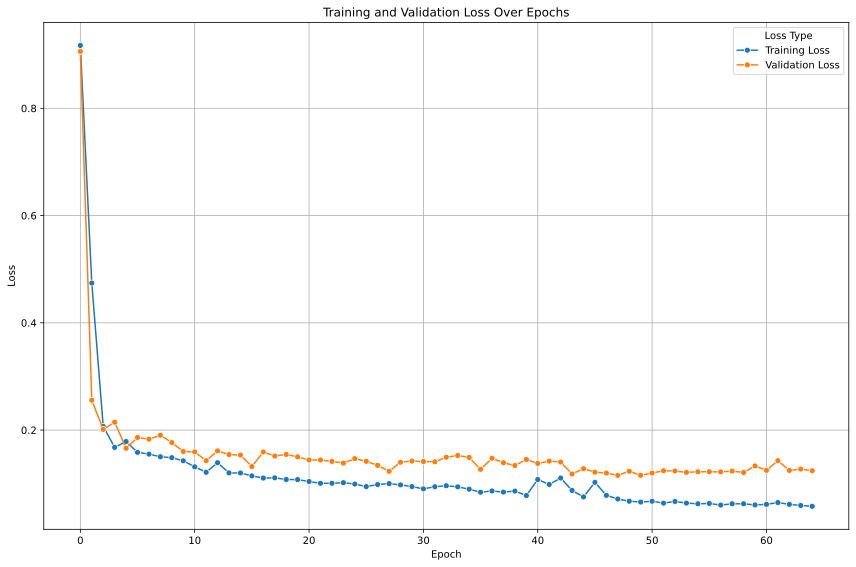

In [34]:
# 🔹 Define the path to the saved SVG file for the best trial's training & validation loss evolution
svg_file_path = os.path.join(tuning_dir, "best_trial", "train_val_loss_evolution.svg")

# ✅ Display the SVG file inside the Jupyter Notebook
print(f"📄 Displaying SVG file: {svg_file_path}")
SVG(svg_file_path)  # Loads and renders the SVG image in the notebook
